In [23]:
%load_ext autoreload
%autoreload 2

import gc
import os
import pickle
from collections import Counter

import numpy
import pandas
from keras.models import load_model
from keras import Input, Model
from keras.layers import Lambda, subtract, concatenate
from sklearn.externals import joblib

from hwgen.common import get_meta_data, get_all_assignments, get_all_attempts, get_student_list, make_gb_question_map
from hwgen.deep.ttb_evaluate import evaluate3, class_evaluation, evaluate_by_bucket
from hwgen.deep.ttb_scorecards import create_student_scorecards
from hwgen.deep.ttb_utils import build_SXUA, train_deep_model, create_assignment_summary, \
    augment_data, build_start_dates
from hwgen.profiler import get_attempts_from_db

from importlib import reload
from matplotlib import pyplot as plt

import math

print("started")

use_saved = True
do_train = True
do_testing = True
create_scorecards = True

base = "../../../isaac_data_files/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
started


In [4]:
USE_CACHED_ASSGTS = True
SAVE_CACHED_ASSGTS = True
cache_fname = base + "cached_assgts.csv"
if USE_CACHED_ASSGTS:
    print("using cached assets")
    ass_summ = pandas.read_csv(base + "ass_summ.csv")
    ass_summ.loc[:, "creation_date"] = pandas.to_datetime(ass_summ["creation_date"]).dt.floor("D")
else:
    print("not using cached assets ... creating...")
    ass = get_all_assignments()
    #ass = filter_assignments(ass, book_only=False)
    ass_summ = create_assignment_summary(ass)
    if SAVE_CACHED_ASSGTS:
        ass.to_csv(cache_fname)
        ass_summ.to_csv(base + "ass_summ.csv")
        
print(ass_summ.shape)

using cached assets
(29158, 10)


In [5]:
from keras import backend as K
from keras.constraints import Constraint
from keras.engine.topology import Layer
from keras import initializers

class WeightClip(Constraint):
    '''Clips the weights incident to each hidden unit to be inside a range
    '''
    def __init__(self, min_w=0, max_w=4):
        self.min_w = min_w
        self.max_w = max_w

    def __call__(self, p):
        return K.clip(p, self.min_w, self.max_w)

    def get_config(self):
        return {'name': self.__class__.__name__,
                'min_w': self.min_w,
                'max_w': self.max_w }

In [6]:
from keras import constraints
class BigTable(Layer):

    def __init__(self, _dim, min_w, max_w, **kwargs):
        self.dim = _dim
        self.hilo = kwargs["init_hilo"]
        kwargs.pop('init_hilo', None)
        self.limits = (min_w, max_w)
        kc =kernel_constraint=WeightClip(min_w, max_w)
        self.kernel_constraint= constraints.get(kc)
        super(BigTable, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        min_w, max_w = self.limits
#         initialiser = initializers.RandomUniform(av_w*0.99, av_w*1.01)  #.RandomUniform(min_w, max_w)
        if self.hilo:
            if self.hilo=="hi":
                initialiser = initializers.RandomUniform(max_w*.9, max_w)
            elif self.hilo=="lo":
                initialiser = initializers.RandomUniform(min_w, min_w*1.1)
            elif self.hilo=="av":
                av_w = (min_w + max_w)/2.0
                initialiser = initializers.RandomUniform(av_w*0.9, av_w*1.1)
            elif self.hilo=="all":
                initialiser = initializers.RandomUniform(min_w, max_w)
#             elif self.hilo is int:
#                 w = self.hilo
#                 initialiser = initializers.RandomUniform(av_w*0.9, av_w*1.1)
            
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(self.dim),
                                      initializer=initialiser,
                                      trainable=True,
                                      constraint=self.kernel_constraint)
        print("kk", self.kernel.shape)
        super(BigTable, self).build(input_shape)  # Be sure to call this at the end

    def call(self, selector):
        print("selector shape", selector.shape)
        selector = K.flatten(selector)
        print("flat selector shape", selector.shape)
        print("call kk", self.kernel.shape)
#         selector = tf.Print(selector, [selector], message="selector is:", first_n=-1, summarize=1024)
        rows = K.gather(self.kernel, selector)
#         rows = tf.Print(rows, [rows], message="row is:", first_n=-1, summarize=1024)
        print("'rows' shape,",rows.shape)
        return rows

    def compute_output_shape(self, input_shape):
        return ((None, self.dim[1]))


In [166]:
from keras.layers import add
def generate_qs_model(qn_table, psi_table, optimiser):
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    print(qn_table, psi_table, psi_sel, qn_sel)
    print("psi_sel shape", psi_sel.shape)

    psi_table.trainable=True
    qn_table.trainable=True
    
    qn_row = qn_table(qn_sel)    
    psi_row = psi_table(psi_sel)
#     q_ws = qn_table.kernel
#     s_ws = psi_table.kernel

#     qn_row = Lambda(lambda q: K.clip(q,1,math.inf))(qn_row)
#     psi_row = Lambda(lambda s: K.clip(s,1,math.inf))(psi_row)
    
#     q_masque = Lambda(lambda q: K.clip(q,0,1))(qn_row)
#     s_masque = Lambda(lambda s: K.clip(s,0,1))(psi_row)

#     qn_row = Lambda(lambda q: K.clip(q,1,math.inf))(qn_row)
#     psi_row = Lambda(lambda s: K.clip(s,1,math.inf))(psi_row)
    
    difs = subtract([psi_row, qn_row])
#     print("dif",dif.shape)
#     comps = Lambda(lambda ps_q: (14*ps_q[0]*ps_q[1]) + 14*(1.0-ps_q[1]) -7 ) ([psi_row, qn_row])
    Prs = Lambda(lambda z: (1.0 / (1.0 + K.exp(-z))), name="Pr_sigmoid1")(difs)
#     comps = Lambda(lambda ps_q: (14*ps_q[0]*ps_q[1]) + 14*(1.0-ps_q[1]) -7 ) ([psi_row, qn_row])
#     Prs = Lambda(lambda ps_q: ps_q[2]*ps_q[0]*ps_q[1] + (1-ps_q[1])) ([s_masque, q_masque, Prs])

#     #MULTI LAYER SIGMOID LOGIC
#     notqc = Lambda(lambda q: 20.0*q -10.0)(qn_row)
#     notq = Lambda(lambda z: 1.0 / (1.0 + K.exp(-z)))(notqc)
#     comps = Lambda(lambda ps_q: 20.0*ps_q[0] + 20.0*ps_q[1] -10.0 )([notq, psi_row])
#     Prs = Lambda(lambda z: 1.0 / (1.0 + K.exp(-z)), name="Pr_sigmoid2")(comps)
    Pr = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="sPr_prod")(Prs)
#     Pr = Lambda(lambda ps: K.min(ps, axis=1, keepdims=True), name="sPr_prod")(Prs)
#     Ws = Lambda(lambda r: K.sum(r, axis=None, keepdims=True))(qn_row)
#     Wq = Lambda(lambda r: K.sum(r, axis=None, keepdims=True))(psi_row)

#     W = concatenate([qn_row, psi_row], name="add_w", axis=1)

#     W = add([Ws, Wq])

    print("Pr",Pr.shape)
#     model = Model(inputs=[qn_sel, psi_sel], outputs=[Pr,W])
#     model.compile(optimizer=optimiser, loss=["binary_crossentropy","mae"], metrics=["mse","accuracy"], loss_weights=[1,0.1])
    model = Model(inputs=[qn_sel, psi_sel], outputs=Pr)
    model.compile(optimizer=optimiser, loss=["binary_crossentropy"], metrics=["mse","accuracy"])

    return model

In [8]:
load_from_file = True

if load_from_file:
    attz_all = pandas.read_csv("attz_all.csv")
else:
    attz = get_all_attempts()
    attz["date"] = attz.timestamp.dt.date
#     d_hist_data = {}
#     qids_seen = set()
#     uids_seen = set()
#     uids_counter = Counter()
#     book_qids = set()
#     uids_across_days = []
    print("copying..")
    attz_all = attz.copy()
    print("copied, saving..")
    attz_all.to_csv("attz_all.csv")
    print("saved.")
dates = attz_all.date.unique()
dates = pandas.Series(dates).sort_values()
print(type(dates))
print(len(attz_all))

/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.series.Series'>
24500941


In [9]:
# print(len(uids_across_days), "effective static users")
# # print(uids_counter.most_common(100))

# for pad in sorted(uids_across_days):
#     print(pad)

In [93]:
from keras.optimizers import Adam

# last_qn_table = [0 for q in qids_seen]

dates_to_use = dates[365:(365*2)]
attz_to_use = attz_all[(attz_all["date"]>min(dates_to_use)) & (attz_all["date"]<max(dates_to_use))]
print(len(attz_to_use))
attz_to_use.fillna(0, inplace=True)

print(attz_to_use["question_id"][0:10])

attz_to_use = attz_to_use[attz_to_use.user_id.apply(lambda x: x.isnumeric())]
print(len(attz_to_use))

uids_seen = list(attz_to_use.user_id.unique())
# users_subsample = numpy.random.choice(uids_seen, size=min(100, len(uids_seen)), replace=False)
# subsample = attz_to_use[attz_to_use.user_id.isin(users_subsample)]
# subsample = attz_to_use

# qs_subsample = attz_to_use[(attz_to_use.question_id.str.startswith("ch_") | attz_to_use.question_id.str.startswith("ch-"))]
# subsample = qs_subsample #[-100000:]
# print(qs_subsample)
# print(len(qs_subsample))
qs_subsample = attz_to_use

users_subsample = numpy.random.choice(uids_seen, size=min(1000, len(uids_seen)), replace=False)
# users_subsample = numpy.random.choice(uids_seen, size=len(uids_seen), replace=False)
subsample = qs_subsample[qs_subsample.user_id.isin(users_subsample)]
print(len(subsample))

# subsample = attz_to_use[-100000:]
subsample.fillna(0, inplace=True)
subsample["uid_d"] = subsample["user_id"] + "_" + subsample["date"].map(str)

uids_across_days = list(numpy.sort(subsample["uid_d"].unique()))
subsample["sindex"] = subsample["uid_d"].apply(lambda x: uids_across_days.index(x))

qids_seen = list(numpy.sort(subsample["question_id"].unique()))
subsample["qindex"] = subsample["question_id"].apply(lambda x: qids_seen.index(x))

sz = subsample["sindex"]
qz = subsample["qindex"]
pfz = subsample["correct"]

from collections import defaultdict

counts=Counter()
pazzed=Counter()
for s,q,pf in zip(sz, qz, pfz):
    counts[(s,q)] += 1
    if pf:
        pazzed[(s,q)] += 1
#     print(s,q,"=>",counts[(s,q)], pazzed[(s,q)])
        
probs = defaultdict(float)
probs_list = []
unpassed = {}
unfailed = {}
qcounts = Counter()
for q in qz:
    unpassed[q]=True
    unfailed[q]=True
    qcounts[q]+=1
    
for s,q in counts:
    if pazzed[(s,q)] > 0:
        unpassed[q] = False
        p = 1.0 / (counts[(s,q)] -pazzed[(s,q)] +1)
        probs[(s,q)] = p
        probs_list.append(p)
    else:
        unfailed[q] =False
    print(s,q,"=>",probs[(s,q)])
    
print(len(sz), len(qz), len(pfz))

2979104


/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/pandas/core/frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


257           ch_f_p3|3dfab744-0ed3-4b8a-bf32-0d18bc30ffcb
353           ch_f_p3|f1020c1e-d80f-4066-a9de-db3b990e9d42
357           ch_f_p3|db87afb2-f240-4cc5-ae68-4cc823988a9e
1510          ch_f_p3|b5adae83-3a04-4af3-9766-4ee9aa296b8a
2062          ch_f_p3|af6c6136-ef6d-4604-9b41-d97329dbbf92
2120          ch_f_p3|f1020c1e-d80f-4066-a9de-db3b990e9d42
2605     humpback_bridge|11885e75-3939-42fc-9894-d710a7...
2608          ch_f_p3|ab2a7ff3-5043-4e97-8d53-56bd24b68052
3337          ch_f_p3|64926716-9b1c-4135-acbe-9e9827d0e7ed
15569         ch_f_p3|4f6d4391-2919-4731-87eb-db38646b89af
Name: question_id, dtype: object
2780085
147238


/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

2875 792 => 1.0
2875 789 => 1.0
2875 793 => 0.3333333333333333
2875 788 => 1.0
2875 775 => 1.0
2875 782 => 1.0
2875 778 => 1.0
3245 761 => 0.5
2875 774 => 1.0
3370 2364 => 1.0
2875 790 => 1.0
3245 759 => 1.0
2875 779 => 1.0
2875 783 => 1.0
2875 780 => 1.0
2875 777 => 1.0
2875 784 => 1.0
3245 756 => 0.1111111111111111
2875 785 => 1.0
3364 1257 => 0.5
2875 787 => 1.0
2875 781 => 1.0
3364 2295 => 1.0
2875 776 => 1.0
3364 2142 => 0.5
3364 2143 => 0.2
3245 758 => 0.5
2875 786 => 1.0
3245 760 => 0.0
2875 791 => 1.0
3364 2141 => 0.0
3245 757 => 0.5
3245 754 => 1.0
3245 763 => 1.0
3364 2140 => 0.0
3364 1903 => 1.0
3364 1902 => 1.0
3364 1503 => 0.5
3364 1154 => 1.0
3364 194 => 1.0
3364 1601 => 1.0
3364 1334 => 1.0
3364 2071 => 0.2
3364 2382 => 1.0
3047 350 => 0.0
3047 356 => 0.0
3245 2477 => 1.0
3245 770 => 0.1
3358 404 => 0.5
3358 403 => 1.0
3358 399 => 0.5
2875 1632 => 0.5
3358 401 => 1.0
3358 400 => 1.0
3358 398 => 1.0
3358 397 => 1.0
3358 394 => 0.5
3358 402 => 1.0
3358 396 => 1.0
2875 1633

3361 473 => 0.5
1835 2256 => 1.0
1835 157 => 0.2
3361 476 => 1.0
3361 471 => 1.0
1835 1255 => 1.0
3361 470 => 0.5
1835 170 => 0.1
3361 474 => 0.5
3361 467 => 1.0
3361 477 => 0.25
3361 480 => 0.5
3361 478 => 1.0
3361 475 => 1.0
3361 469 => 1.0
3361 479 => 1.0
1835 169 => 0.5
1835 1222 => 0.2
2957 288 => 1.0
2957 285 => 1.0
2957 286 => 1.0
2957 280 => 1.0
2957 283 => 0.5
2957 278 => 1.0
2957 284 => 0.3333333333333333
2957 282 => 0.5
2957 287 => 0.5
2957 281 => 0.0
2957 289 => 0.0
2957 279 => 0.0
2957 303 => 0.3333333333333333
2957 299 => 0.5
2957 320 => 1.0
2957 310 => 1.0
2957 309 => 1.0
2957 317 => 0.5
2957 295 => 1.0
2957 326 => 1.0
2957 306 => 1.0
2957 297 => 1.0
2957 318 => 1.0
2957 316 => 1.0
2957 308 => 0.5
2957 325 => 1.0
3640 285 => 1.0
3640 288 => 1.0
2957 294 => 1.0
2957 315 => 1.0
3640 286 => 0.3333333333333333
2957 307 => 0.3333333333333333
2957 290 => 0.25
2957 322 => 1.0
2957 312 => 0.3333333333333333
3640 280 => 0.5
2957 305 => 1.0
2957 292 => 0.5
2957 323 => 1.0
2957 311

3824 330 => 0.3333333333333333
3824 332 => 1.0
3626 281 => 1.0
3780 258 => 1.0
3780 1876 => 0.5
3780 2045 => 1.0
3780 2044 => 1.0
3780 2472 => 0.0
3780 2471 => 1.0
3780 1329 => 0.0
3815 328 => 1.0
3815 333 => 1.0
3815 335 => 1.0
3815 336 => 1.0
3815 330 => 1.0
3815 332 => 1.0
3815 331 => 0.5
3815 337 => 1.0
3815 327 => 1.0
3815 329 => 0.14285714285714285
3095 1662 => 0.5
3815 334 => 1.0
3815 338 => 1.0
3095 1663 => 0.5
3095 85 => 0.5
3095 258 => 0.5
3095 1339 => 0.25
3095 164 => 1.0
3095 1893 => 1.0
3095 1894 => 0.3333333333333333
3008 837 => 0.25
3008 838 => 1.0
3008 839 => 0.1
3095 1895 => 0.3333333333333333
3008 843 => 0.5
3095 2395 => 1.0
3838 2478 => 0.14285714285714285
3008 840 => 0.0
3095 2411 => 1.0
3008 841 => 1.0
3008 846 => 1.0
3425 798 => 0.25
3008 842 => 1.0
3425 796 => 1.0
3838 2509 => 0.3333333333333333
3425 800 => 0.3333333333333333
3008 844 => 1.0
3425 803 => 1.0
3008 829 => 1.0
3008 831 => 1.0
3008 830 => 0.5
3008 835 => 1.0
3008 833 => 1.0
3425 801 => 0.5
3008 832 =>

3825 321 => 1.0
3825 313 => 1.0
3825 301 => 1.0
3825 296 => 0.25
4029 351 => 1.0
4029 359 => 1.0
3825 319 => 0.25
3825 300 => 0.3333333333333333
3825 298 => 0.25
4029 352 => 0.3333333333333333
3825 349 => 0.07692307692307693
4029 355 => 1.0
4029 350 => 0.5
4029 356 => 0.25
4029 358 => 1.0
4029 360 => 0.25
3275 1196 => 0.5
4029 361 => 1.0
4029 369 => 1.0
3275 1195 => 1.0
4029 365 => 0.25
4029 364 => 0.5
4029 362 => 0.5
4029 366 => 0.5
4029 371 => 0.5
4029 372 => 1.0
4029 363 => 1.0
4029 370 => 0.5
4029 367 => 0.5
4029 368 => 1.0
4029 373 => 1.0
3607 285 => 1.0
4029 354 => 0.25
4029 378 => 1.0
4029 375 => 0.25
3182 1672 => 1.0
3182 1674 => 1.0
3182 1673 => 1.0
4029 376 => 0.2
3182 1580 => 0.5
3881 303 => 1.0
3182 1577 => 1.0
3881 299 => 1.0
3881 320 => 1.0
3182 1579 => 1.0
4029 374 => 0.07692307692307693
3182 1581 => 0.5
4029 377 => 1.0
3182 1578 => 1.0
3182 1582 => 1.0
3182 1583 => 1.0
4029 382 => 1.0
4029 380 => 0.0
3182 1584 => 1.0
3182 1585 => 1.0
3182 1586 => 1.0
3182 2462 => 1.0
31

3799 1628 => 0.0
3746 108 => 0.1111111111111111
3799 85 => 0.5
3799 258 => 1.0
3739 283 => 0.14285714285714285
3746 112 => 0.5
3168 285 => 1.0
4170 1876 => 1.0
3168 288 => 1.0
4170 2436 => 1.0
3168 286 => 1.0
4170 114 => 1.0
4099 2510 => 1.0
4170 111 => 1.0
4170 110 => 1.0
4170 109 => 1.0
3168 280 => 0.5
4170 113 => 0.5
4170 108 => 0.5
4170 112 => 1.0
3168 283 => 1.0
4170 2569 => 0.3333333333333333
3168 278 => 1.0
4170 1918 => 0.3333333333333333
3168 284 => 0.3333333333333333
3739 278 => 1.0
3739 284 => 0.5
4170 1917 => 0.0
4171 328 => 1.0
4171 333 => 1.0
3739 282 => 0.5
4171 335 => 0.5
3739 287 => 1.0
3651 306 => 0.0
4171 336 => 1.0
3168 282 => 1.0
4171 330 => 0.0
3168 287 => 1.0
3168 303 => 0.047619047619047616
4174 266 => 0.0
3168 320 => 0.2
3168 299 => 0.2
4174 270 => 0.0
3168 310 => 0.5
4174 276 => 0.5
3168 309 => 0.5
3168 317 => 0.14285714285714285
3168 295 => 1.0
3168 326 => 1.0
4174 275 => 0.0
4174 271 => 0.0
3168 306 => 1.0
3168 297 => 0.5
4174 273 => 0.0
4174 274 => 0.0
4174 

4138 330 => 0.0
3531 979 => 1.0
4138 349 => 0.0
3531 967 => 0.25
3531 971 => 1.0
3531 974 => 1.0
3531 980 => 1.0
3531 965 => 0.5
3531 978 => 0.3333333333333333
3531 968 => 1.0
3531 973 => 1.0
3531 966 => 1.0
3531 964 => 0.5
3531 977 => 0.5
3531 976 => 0.3333333333333333
3558 266 => 0.5
3558 270 => 1.0
3531 970 => 1.0
3558 275 => 0.3333333333333333
3531 972 => 1.0
3531 981 => 1.0
3668 820 => 0.3333333333333333
3558 273 => 1.0
3558 271 => 0.5
3558 274 => 1.0
3531 969 => 1.0
3558 272 => 0.25
3668 827 => 0.3333333333333333
3531 975 => 0.5
3558 277 => 1.0
3751 1156 => 0.0
3558 268 => 0.3333333333333333
3751 2510 => 0.2
3751 1659 => 1.0
2958 1491 => 0.0
3751 114 => 0.0
3531 963 => 1.0
3668 826 => 0.5
3558 269 => 1.0
3668 819 => 1.0
3668 821 => 1.0
3668 822 => 0.0625
3558 276 => 1.0
3668 828 => 1.0
3668 824 => 1.0
4353 285 => 1.0
3668 825 => 1.0
4353 288 => 1.0
4353 286 => 1.0
3668 823 => 1.0
4353 280 => 1.0
4353 283 => 1.0
4353 278 => 0.5
3440 285 => 1.0
4353 284 => 0.3333333333333333
3440 2

4089 284 => 1.0
3892 270 => 1.0
4361 303 => 0.14285714285714285
3892 275 => 0.25
4089 282 => 1.0
4361 299 => 0.125
4361 320 => 0.08333333333333333
4089 287 => 1.0
4089 281 => 1.0
3892 273 => 0.25
4089 289 => 0.3333333333333333
4361 310 => 0.5
4361 309 => 0.14285714285714285
4361 317 => 0.16666666666666666
4361 295 => 0.1
4089 279 => 1.0
3892 271 => 1.0
3892 274 => 1.0
4361 326 => 0.25
3892 272 => 1.0
3892 277 => 0.5
4361 306 => 1.0
4361 297 => 0.5
4361 318 => 0.09090909090909091
4361 316 => 0.2
4361 308 => 0.3333333333333333
4361 294 => 0.0
4089 303 => 0.5
4089 306 => 1.0
4089 299 => 0.25
4089 320 => 1.0
4089 310 => 0.3333333333333333
4089 309 => 1.0
4089 317 => 1.0
4089 295 => 1.0
4089 326 => 1.0
3365 2141 => 0.3333333333333333
3800 328 => 1.0
3800 333 => 1.0
3800 335 => 1.0
3800 336 => 1.0
3800 330 => 0.0
3365 2140 => 1.0
3800 332 => 0.0
3800 331 => 1.0
3800 337 => 0.5
3800 327 => 1.0
3800 329 => 0.0
3800 334 => 0.25
3800 338 => 0.3333333333333333
3800 349 => 0.0
3800 345 => 0.0
3800

4688 353 => 1.0
4688 359 => 1.0
4688 352 => 0.16666666666666666
4688 355 => 1.0
4688 360 => 1.0
4688 361 => 0.3333333333333333
4688 369 => 0.3333333333333333
4688 365 => 1.0
4688 364 => 1.0
2954 987 => 1.0
2954 988 => 1.0
2954 986 => 1.0
2954 991 => 1.0
2954 989 => 1.0
2954 982 => 1.0
2954 990 => 1.0
2954 992 => 1.0
4575 706 => 1.0
4575 712 => 0.5
2954 984 => 0.5
4218 1638 => 0.14285714285714285
4575 720 => 0.5
2954 983 => 1.0
4575 711 => 1.0
2954 985 => 1.0
4575 723 => 1.0
4322 394 => 0.0
4575 734 => 0.0
4575 730 => 0.0
2954 1001 => 0.3333333333333333
2954 1009 => 0.3333333333333333
2954 1000 => 0.5
3914 328 => 1.0
3914 333 => 1.0
3914 335 => 1.0
3914 336 => 1.0
3914 330 => 1.0
3914 332 => 1.0
3914 331 => 0.5
3914 337 => 0.3333333333333333
2954 999 => 1.0
3914 327 => 1.0
3914 329 => 0.3333333333333333
3914 334 => 1.0
4218 2043 => 1.0
3914 338 => 0.25
4697 352 => 0.03333333333333333
4697 355 => 1.0
4697 356 => 0.14285714285714285
2954 1007 => 1.0
2954 1004 => 1.0
4697 350 => 0.14285714

3466 297 => 1.0
3466 318 => 1.0
3466 316 => 1.0
3466 308 => 1.0
3466 294 => 1.0
3466 325 => 1.0
3466 315 => 1.0
3466 307 => 1.0
3466 290 => 0.5
3466 322 => 1.0
3466 312 => 1.0
3466 305 => 1.0
3466 292 => 1.0
3466 323 => 1.0
3466 311 => 1.0
3466 302 => 0.5
3466 291 => 1.0
3466 324 => 1.0
3466 314 => 1.0
3466 304 => 0.16666666666666666
3466 293 => 0.5
3466 321 => 1.0
3466 313 => 1.0
3466 301 => 1.0
3466 296 => 1.0
3466 319 => 1.0
3466 300 => 1.0
3466 298 => 0.25
3466 328 => 1.0
3466 333 => 1.0
3466 335 => 1.0
3466 336 => 1.0
3466 330 => 1.0
3466 332 => 0.5
3466 331 => 1.0
3466 337 => 1.0
3466 327 => 1.0
3466 329 => 0.5
3466 334 => 1.0
3466 338 => 0.5
3466 349 => 0.03225806451612903
3466 345 => 1.0
3466 342 => 1.0
3466 344 => 1.0
3466 340 => 0.07142857142857142
3466 346 => 0.25
3466 341 => 0.1111111111111111
3466 339 => 0.25
3466 347 => 0.0
3466 343 => 0.0
4377 331 => 1.0
4377 337 => 0.5
4377 342 => 0.5
4377 348 => 0.0
4377 344 => 1.0
4377 340 => 0.5
4377 346 => 1.0
4377 341 => 1.0
4377 3

4298 1567 => 1.0
4032 519 => 0.3333333333333333
3724 388 => 1.0
128 978 => 1.0
4032 513 => 0.5
128 968 => 0.5
128 979 => 1.0
128 967 => 1.0
128 971 => 1.0
128 974 => 1.0
4032 516 => 0.2
128 965 => 0.5
128 980 => 1.0
4032 522 => 0.5
128 973 => 1.0
4032 515 => 0.25
128 966 => 1.0
128 964 => 1.0
128 977 => 0.5
3718 1049 => 0.0
128 976 => 0.5
4032 520 => 1.0
128 970 => 0.5
128 972 => 1.0
4032 518 => 1.0
4032 514 => 1.0
4032 534 => 1.0
128 981 => 1.0
4032 526 => 1.0
4032 529 => 1.0
3701 404 => 1.0
3701 403 => 1.0
4032 523 => 1.0
3701 399 => 1.0
4032 528 => 1.0
4032 530 => 1.0
3701 401 => 1.0
4032 533 => 1.0
3701 400 => 1.0
4032 527 => 1.0
4032 524 => 1.0
3701 398 => 1.0
128 761 => 1.0
3701 394 => 1.0
128 759 => 0.5
3701 402 => 1.0
3701 396 => 1.0
3701 395 => 1.0
128 758 => 1.0
3701 405 => 1.0
128 760 => 0.0
128 969 => 1.0
3701 397 => 1.0
4298 1564 => 1.0
4601 826 => 1.0
4601 819 => 1.0
4601 821 => 1.0
4601 822 => 0.2
3399 737 => 1.0
3399 741 => 0.5
4601 828 => 1.0
4601 824 => 1.0
4601 825 =

4052 298 => 0.5
4052 735 => 1.0
4052 744 => 0.2
4299 1559 => 0.0
4052 737 => 1.0
4052 740 => 0.5
83 347 => 0.0
3896 975 => 1.0
93 328 => 1.0
93 333 => 1.0
93 335 => 1.0
93 336 => 1.0
93 330 => 1.0
93 332 => 1.0
93 331 => 0.5
93 337 => 0.3333333333333333
3479 1990 => 1.0
93 327 => 1.0
93 334 => 1.0
93 329 => 1.0
93 338 => 1.0
26 875 => 1.0
93 349 => 0.14285714285714285
26 876 => 0.16666666666666666
3565 436 => 0.5
26 880 => 1.0
93 345 => 0.5
93 342 => 1.0
93 344 => 0.14285714285714285
26 879 => 0.5
26 872 => 1.0
93 340 => 0.2
26 877 => 1.0
26 878 => 1.0
93 346 => 1.0
26 873 => 0.5
93 341 => 0.25
26 874 => 0.5
26 881 => 0.5
93 339 => 0.5
93 347 => 0.024390243902439025
3565 443 => 0.3333333333333333
93 348 => 0.0
93 2329 => 0.2
85 542 => 1.0
85 551 => 1.0
85 539 => 1.0
85 548 => 1.0
85 544 => 1.0
85 536 => 1.0
85 541 => 1.0
3479 1634 => 0.2
85 535 => 0.5
85 547 => 1.0
85 550 => 1.0
85 540 => 1.0
85 543 => 1.0
85 538 => 1.0
85 537 => 1.0
85 546 => 1.0
85 545 => 1.0
85 549 => 1.0
3565 440 =

3287 633 => 0.5
3287 645 => 0.3333333333333333
4579 354 => 1.0
3287 640 => 1.0
4526 332 => 0.0
3287 644 => 0.3333333333333333
3995 743 => 0.5
3287 643 => 0.3333333333333333
3287 642 => 0.3333333333333333
3362 1503 => 0.3333333333333333
3287 641 => 0.07142857142857142
3727 2395 => 1.0
3287 634 => 1.0
3362 2140 => 1.0
3727 2019 => 0.3333333333333333
3287 635 => 0.5
2886 820 => 1.0
3362 194 => 0.5
2886 827 => 1.0
3287 638 => 0.07142857142857142
2886 826 => 1.0
2886 819 => 1.0
2886 821 => 1.0
3727 1641 => 0.2
3362 1903 => 0.3333333333333333
3287 637 => 0.1111111111111111
2886 822 => 0.07692307692307693
3362 1902 => 1.0
3727 258 => 1.0
3362 2382 => 1.0
3727 1100 => 0.5
3727 1098 => 0.3333333333333333
3362 1257 => 0.5
2886 828 => 1.0
3727 1099 => 1.0
3727 1648 => 0.5
2886 824 => 1.0
2886 825 => 1.0
2886 823 => 0.25
3362 1601 => 1.0
3727 2220 => 0.0
3362 2071 => 0.5
3362 1154 => 1.0
3362 1334 => 0.14285714285714285
4027 1634 => 1.0
4027 1635 => 1.0
4027 1879 => 0.3333333333333333
4027 1118 =>

31 517 => 0.07692307692307693
4481 415 => 1.0
4481 412 => 0.5
4481 411 => 1.0
4481 409 => 1.0
4589 1603 => 0.0625
31 521 => 0.07142857142857142
4481 406 => 0.0
4686 2373 => 0.3333333333333333
31 534 => 1.0
31 526 => 1.0
31 529 => 0.5
4481 408 => 0.0
4481 416 => 0.0
4686 1537 => 0.0
4686 2376 => 0.0
3875 361 => 1.0
3875 360 => 1.0
3875 369 => 1.0
3875 365 => 1.0
3875 362 => 1.0
3875 364 => 1.0
3805 407 => 0.3333333333333333
3875 366 => 0.5
4406 504 => 0.5
4406 510 => 1.0
4406 512 => 0.5
4406 505 => 1.0
4406 511 => 0.5
4406 507 => 1.0
4406 503 => 0.3333333333333333
4406 501 => 1.0
4406 509 => 1.0
4406 506 => 1.0
4406 508 => 1.0
4406 502 => 0.0
4406 519 => 0.0
4406 513 => 1.0
4406 516 => 0.0
4406 522 => 1.0
4406 515 => 0.5
4406 520 => 0.0
4406 742 => 1.0
4406 736 => 1.0
4406 735 => 0.0
4406 744 => 1.0
4406 737 => 0.0
4406 739 => 1.0
4406 741 => 1.0
4406 740 => 0.3333333333333333
4406 738 => 0.0
4406 743 => 0.0
4406 746 => 0.5
4406 747 => 1.0
4406 745 => 1.0
4406 753 => 0.5
4406 748 => 0.5

329 759 => 0.0
329 758 => 1.0
329 760 => 0.16666666666666666
2849 806 => 1.0
2849 810 => 1.0
329 762 => 1.0
2849 809 => 0.25
4077 883 => 0.16666666666666666
329 756 => 1.0
2849 812 => 0.2
3569 407 => 1.0
3569 410 => 1.0
329 757 => 1.0
2849 807 => 1.0
4077 891 => 0.16666666666666666
2849 808 => 0.3333333333333333
3569 413 => 1.0
3569 406 => 1.0
3569 415 => 1.0
3569 412 => 1.0
3569 411 => 1.0
3569 408 => 1.0
3569 409 => 1.0
3569 416 => 1.0
3569 414 => 1.0
4077 882 => 0.5
2849 1611 => 0.2
4009 328 => 1.0
4009 333 => 1.0
4009 335 => 1.0
4009 336 => 0.5
4009 330 => 0.2
329 754 => 0.5
4009 332 => 1.0
4009 331 => 0.16666666666666666
2849 1612 => 0.09090909090909091
4009 337 => 1.0
4009 327 => 1.0
4009 329 => 0.5
4077 889 => 0.0625
4009 334 => 0.5
329 755 => 1.0
4009 338 => 0.5
4077 890 => 1.0
329 763 => 0.5
2849 1609 => 0.0
4009 349 => 1.0
4009 345 => 1.0
4077 885 => 1.0
2849 1588 => 1.0
3051 811 => 0.08333333333333333
4077 884 => 1.0
4653 416 => 0.0
4077 888 => 0.5
329 770 => 1.0
4543 798 =>

4010 301 => 0.5
4314 792 => 1.0
4314 789 => 1.0
2798 1015 => 1.0
4010 296 => 1.0
2945 957 => 1.0
472 775 => 1.0
4010 319 => 0.5
4010 300 => 0.3333333333333333
2945 954 => 0.3333333333333333
472 779 => 1.0
472 783 => 1.0
4010 298 => 0.5
472 790 => 0.125
2945 958 => 1.0
2945 960 => 1.0
4010 302 => 0.5
4010 291 => 0.0
4010 324 => 1.0
4010 314 => 0.0
2798 1032 => 0.07692307692307693
4314 793 => 0.3333333333333333
472 781 => 0.3333333333333333
472 784 => 1.0
374 303 => 0.0
374 328 => 1.0
374 333 => 1.0
2945 953 => 0.0
374 335 => 1.0
374 336 => 1.0
2798 1014 => 0.5
374 330 => 0.125
4314 788 => 0.0
374 332 => 0.5
374 331 => 0.5
374 337 => 0.2
374 327 => 1.0
374 329 => 0.25
649 761 => 1.0
374 334 => 0.25
374 338 => 0.5
649 759 => 1.0
374 349 => 0.0
374 345 => 0.0
374 342 => 0.0
649 758 => 0.2
374 344 => 0.0
649 760 => 0.0
374 360 => 0.25
374 361 => 0.25
374 369 => 0.2
374 365 => 0.3333333333333333
649 756 => 0.0
19 534 => 0.5
19 526 => 1.0
649 762 => 1.0
19 529 => 1.0
649 757 => 0.5
19 523 => 

3847 725 => 0.3333333333333333
3847 733 => 0.5
3847 729 => 0.3333333333333333
3847 741 => 0.5
3847 740 => 0.0
4615 818 => 0.07692307692307693
4394 873 => 1.0
4394 874 => 1.0
4394 881 => 1.0
4615 817 => 0.2
4615 813 => 0.0
3847 738 => 0.0
4616 814 => 0.09090909090909091
4616 816 => 0.2
4616 813 => 0.07142857142857142
4616 815 => 0.3333333333333333
3848 738 => 0.0
3848 746 => 0.0
3848 747 => 1.0
3848 753 => 0.5
3848 748 => 0.25
3848 749 => 0.5
3848 745 => 0.25
3848 750 => 1.0
3848 752 => 0.5
3848 751 => 1.0
4344 1825 => 0.25
4344 1826 => 0.5
4665 770 => 1.0
4665 769 => 1.0
4665 766 => 0.25
4665 767 => 0.0
4665 772 => 1.0
4665 771 => 1.0
4665 764 => 0.0
4315 788 => 0.0
4315 775 => 0.0
4603 818 => 0.0
4315 782 => 0.25
4315 798 => 0.16666666666666666
4315 796 => 1.0
105 519 => 0.0
4315 800 => 0.2
307 762 => 1.0
4315 803 => 0.25
4315 802 => 0.25
307 757 => 0.2
307 754 => 0.3333333333333333
307 755 => 0.1
307 763 => 1.0
324 937 => 1.0
307 770 => 1.0
324 928 => 1.0
307 769 => 1.0
324 935 => 0.

2877 137 => 0.5
2877 138 => 1.0
4256 579 => 0.5
4234 579 => 1.0
4256 581 => 0.1
4234 581 => 0.06666666666666667
4256 580 => 1.0
4234 580 => 0.2
4256 577 => 0.3333333333333333
4234 577 => 0.1
4234 585 => 0.1111111111111111
3052 818 => 0.2
4256 585 => 0.14285714285714285
3052 817 => 0.25
4256 578 => 1.0
4234 582 => 0.1
4256 582 => 0.0
4666 792 => 1.0
4666 789 => 1.0
4731 542 => 1.0
4731 545 => 1.0
4731 551 => 1.0
4731 539 => 1.0
156 825 => 0.0
156 823 => 0.0
4666 793 => 0.3333333333333333
4666 788 => 0.3333333333333333
4731 548 => 1.0
4666 775 => 0.0
4731 544 => 1.0
4731 536 => 0.3333333333333333
4731 541 => 1.0
4731 549 => 0.3333333333333333
528 486 => 0.07142857142857142
4731 535 => 1.0
4731 547 => 0.5
561 875 => 0.5
4666 782 => 0.2
4731 550 => 0.5
4666 778 => 0.1111111111111111
4731 540 => 1.0
4731 543 => 0.5
4731 538 => 1.0
4731 537 => 0.3333333333333333
4666 774 => 0.0
4731 546 => 1.0
4731 552 => 1.0
4731 553 => 1.0
528 490 => 0.1111111111111111
4666 790 => 0.5
4666 779 => 0.05
561 

3923 398 => 1.0
3923 397 => 1.0
3923 394 => 0.3333333333333333
578 374 => 0.16666666666666666
578 284 => 0.5
578 282 => 1.0
578 287 => 0.2
578 281 => 0.5
578 289 => 0.5
578 279 => 0.3333333333333333
578 448 => 0.05
578 464 => 0.5
578 453 => 0.2
680 519 => 1.0
680 513 => 0.16666666666666666
578 451 => 0.0
578 462 => 0.14285714285714285
680 516 => 0.3333333333333333
680 522 => 1.0
680 515 => 0.2
308 484 => 1.0
308 481 => 1.0
308 485 => 1.0
308 491 => 1.0
308 487 => 1.0
308 483 => 0.5
308 482 => 1.0
3517 1185 => 1.0
3517 1186 => 0.5
3517 1187 => 1.0
3517 1184 => 0.3333333333333333
4617 770 => 1.0
4617 769 => 1.0
4617 766 => 1.0
3517 1664 => 0.5
4617 767 => 0.2
3517 153 => 0.07692307692307693
4617 772 => 1.0
4617 771 => 1.0
4617 764 => 0.25
4617 768 => 0.16666666666666666
4700 493 => 0.0
4617 765 => 0.16666666666666666
4700 495 => 0.0
4617 798 => 0.5
4617 796 => 1.0
4617 800 => 0.5
4617 803 => 0.5
4617 801 => 0.2
4617 802 => 1.0
4617 794 => 0.25
4617 797 => 0.0
4617 795 => 1.0
4617 799 => 

3441 298 => 0.5
612 332 => 0.5
612 279 => 0.5
612 328 => 0.5
612 333 => 1.0
612 335 => 1.0
612 336 => 1.0
612 331 => 0.125
612 330 => 1.0
612 337 => 1.0
612 327 => 1.0
612 329 => 1.0
612 334 => 0.5
612 338 => 1.0
612 349 => 0.2
612 345 => 0.5
612 342 => 1.0
612 344 => 1.0
612 340 => 1.0
612 346 => 0.14285714285714285
612 341 => 0.125
612 339 => 0.3333333333333333
612 347 => 0.3333333333333333
612 343 => 0.3333333333333333
612 348 => 0.5
565 389 => 0.1
565 391 => 1.0
565 387 => 0.25
565 388 => 0.0
565 386 => 0.08333333333333333
739 820 => 1.0
739 827 => 0.2
739 826 => 1.0
739 819 => 1.0
739 821 => 1.0
739 822 => 0.3333333333333333
739 828 => 1.0
739 824 => 1.0
739 825 => 1.0
739 823 => 1.0
612 357 => 1.0
612 351 => 1.0
612 352 => 0.0
612 355 => 1.0
612 350 => 0.16666666666666666
612 358 => 0.16666666666666666
612 354 => 1.0
612 360 => 0.5
612 361 => 0.3333333333333333
612 369 => 1.0
612 365 => 1.0
612 364 => 1.0
612 362 => 1.0
612 366 => 0.25
612 371 => 0.25
612 372 => 1.0
612 363 => 0.

2816 1166 => 1.0
825 332 => 1.0
825 331 => 1.0
825 337 => 1.0
825 327 => 1.0
825 329 => 1.0
825 334 => 1.0
825 338 => 0.5
2816 2030 => 1.0
825 63 => 0.2
825 64 => 1.0
825 62 => 0.5
3684 378 => 1.0
3684 375 => 1.0
3684 376 => 1.0
3684 374 => 0.2
3684 377 => 0.3333333333333333
4722 392 => 0.0
785 1021 => 0.3333333333333333
785 1018 => 0.16666666666666666
283 792 => 1.0
283 789 => 1.0
283 793 => 0.5
283 788 => 0.2
283 775 => 0.3333333333333333
283 782 => 0.5
283 778 => 1.0
283 774 => 0.3333333333333333
283 783 => 1.0
283 779 => 0.5
283 790 => 0.5
283 780 => 0.3333333333333333
283 777 => 0.5
283 784 => 0.3333333333333333
283 785 => 0.5
283 787 => 0.5
283 781 => 0.5
283 776 => 0.0
283 786 => 0.0
283 791 => 0.5
785 1030 => 0.5
785 1023 => 1.0
785 1027 => 1.0
785 1024 => 0.5
785 1020 => 1.0
785 1011 => 0.25
785 1017 => 1.0
785 1031 => 0.5
841 792 => 1.0
841 789 => 0.5
841 793 => 0.3333333333333333
841 788 => 0.0
841 775 => 1.0
841 782 => 0.0
841 778 => 0.0
841 791 => 0.0
841 774 => 0.0
785 10

273 508 => 1.0
3480 2186 => 0.125
2986 827 => 1.0
2986 826 => 1.0
2986 819 => 1.0
2986 821 => 1.0
3480 2189 => 0.3333333333333333
3480 2187 => 0.0
273 502 => 0.0
830 987 => 0.5
2986 828 => 0.0
830 988 => 1.0
273 519 => 1.0
273 513 => 1.0
273 516 => 0.5
273 522 => 1.0
273 515 => 1.0
273 520 => 1.0
273 518 => 1.0
273 514 => 0.5
273 517 => 1.0
273 521 => 0.0
902 1795 => 0.0
3480 2188 => 0.0
830 986 => 1.0
830 991 => 0.5
830 989 => 1.0
830 982 => 1.0
830 990 => 1.0
898 1816 => 1.0
903 1876 => 1.0
898 2568 => 1.0
898 2566 => 1.0
830 992 => 1.0
830 984 => 0.5
830 983 => 0.5
903 1629 => 0.16666666666666666
830 985 => 1.0
898 2567 => 0.3333333333333333
903 1630 => 0.0
903 1628 => 0.0
903 1627 => 0.0
903 1648 => 1.0
903 2436 => 1.0
903 1642 => 0.3333333333333333
898 1755 => 0.0
903 1809 => 0.0
903 2213 => 1.0
903 2569 => 0.5
898 2575 => 0.0
903 2019 => 0.0
903 1893 => 1.0
903 1894 => 0.0
903 1895 => 0.25
273 534 => 1.0
273 526 => 1.0
273 529 => 0.0
273 523 => 0.25
273 528 => 1.0
273 530 => 1.0


107 539 => 1.0
107 548 => 0.09090909090909091
107 544 => 1.0
107 536 => 1.0
107 541 => 0.5
107 549 => 1.0
107 535 => 1.0
107 547 => 1.0
107 550 => 1.0
107 540 => 0.14285714285714285
2854 266 => 0.5
2854 270 => 0.3333333333333333
2854 275 => 0.25
2854 273 => 1.0
2854 271 => 1.0
2854 274 => 0.5
2854 272 => 1.0
2854 277 => 1.0
2854 268 => 1.0
2854 269 => 1.0
2854 267 => 0.5
2854 276 => 0.14285714285714285
2854 961 => 0.25
2854 959 => 0.1
2854 957 => 0.14285714285714285
2854 954 => 0.1
2854 958 => 0.5
2854 960 => 1.0
2854 953 => 0.16666666666666666
2854 962 => 0.3333333333333333
2854 979 => 1.0
2854 967 => 0.2
2854 971 => 1.0
2854 978 => 1.0
2854 974 => 0.5
2854 965 => 1.0
2854 980 => 1.0
2854 968 => 0.25
2854 973 => 0.25
2854 956 => 0.017543859649122806
2854 955 => 0.25
2854 2261 => 0.125
2854 2262 => 1.0
3434 2081 => 0.25
3434 407 => 0.0
3434 1185 => 1.0
3434 1186 => 0.5
3434 1187 => 1.0
3434 1184 => 0.5
3434 1100 => 0.5
3434 1099 => 0.5
3434 1637 => 0.5
3434 2569 => 1.0
284 798 => 0.333

3293 2177 => 1.0
3293 2178 => 0.2
832 1046 => 1.0
3293 1165 => 1.0
3293 265 => 0.14285714285714285
3293 2029 => 1.0
3293 380 => 0.0
4670 875 => 1.0
4670 876 => 1.0
4670 880 => 0.125
653 883 => 0.2
4670 879 => 1.0
4670 872 => 0.25
4670 877 => 0.2
4670 878 => 1.0
653 891 => 0.0
4670 873 => 1.0
4670 874 => 1.0
4670 881 => 1.0
4670 897 => 1.0
653 875 => 0.5
4670 895 => 1.0
653 876 => 1.0
653 880 => 1.0
653 879 => 1.0
653 872 => 1.0
4670 899 => 0.3333333333333333
653 877 => 1.0
653 878 => 1.0
4670 893 => 1.0
4670 892 => 1.0
653 873 => 1.0
653 874 => 1.0
4670 896 => 0.0
653 881 => 1.0
653 897 => 0.5
653 895 => 1.0
653 899 => 0.3333333333333333
653 893 => 0.16666666666666666
653 892 => 1.0
653 896 => 0.0
3459 907 => 0.0
64 891 => 0.125
64 882 => 0.3333333333333333
64 890 => 1.0
64 889 => 0.0
64 885 => 1.0
64 884 => 0.3333333333333333
64 888 => 1.0
64 887 => 1.0
64 895 => 0.5
3277 595 => 1.0
64 897 => 1.0
64 892 => 0.3333333333333333
64 899 => 0.3333333333333333
3277 588 => 1.0
3277 596 => 0.1

483 785 => 1.0
3347 2090 => 1.0
483 787 => 1.0
483 781 => 1.0
3347 2092 => 0.25
483 776 => 1.0
3347 2093 => 1.0
483 786 => 1.0
483 791 => 1.0
3347 2091 => 0.2
483 407 => 1.0
483 410 => 0.5
483 413 => 1.0
3119 1542 => 0.1111111111111111
3119 1539 => 0.16666666666666666
483 406 => 1.0
3347 2175 => 0.0
483 415 => 0.5
483 412 => 1.0
483 411 => 1.0
483 408 => 1.0
483 409 => 0.5
3119 1540 => 1.0
483 416 => 1.0
483 414 => 0.5
3119 1538 => 1.0
3119 1541 => 1.0
483 920 => 1.0
483 921 => 1.0
483 919 => 0.2
3347 1961 => 1.0
483 918 => 1.0
3347 1960 => 0.0
483 923 => 0.0
1984 798 => 0.1111111111111111
1984 796 => 0.25
483 140 => 1.0
483 139 => 1.0
483 137 => 0.16666666666666666
1984 800 => 1.0
1984 803 => 0.5
1984 801 => 0.5
1984 802 => 1.0
29 923 => 1.0
29 924 => 0.25
29 925 => 1.0
29 906 => 1.0
29 907 => 1.0
29 904 => 1.0
29 905 => 1.0
29 903 => 1.0
29 910 => 1.0
29 908 => 1.0
29 909 => 1.0
29 911 => 1.0
29 902 => 1.0
2799 1070 => 0.5
2799 1068 => 0.1111111111111111
2799 1053 => 0.5
2799 1066 =>

3673 853 => 1.0
3673 849 => 1.0
3673 857 => 0.3333333333333333
2906 2402 => 1.0
2906 2401 => 1.0
3673 852 => 1.0
2906 2400 => 0.3333333333333333
1102 404 => 0.5
1102 401 => 1.0
1102 400 => 0.5
1102 398 => 0.5
791 2182 => 1.0
1102 397 => 1.0
3673 855 => 0.3333333333333333
1102 394 => 0.16666666666666666
915 2181 => 0.0
1042 1515 => 1.0
1042 1514 => 1.0
1042 404 => 0.5
1042 403 => 1.0
2906 2414 => 0.14285714285714285
1042 399 => 1.0
918 404 => 0.0
1102 403 => 1.0
915 398 => 0.0
1102 399 => 1.0
915 397 => 1.0
918 401 => 1.0
1102 402 => 0.5
918 398 => 0.0
1102 396 => 0.5
3673 858 => 0.5
1042 394 => 1.0
1042 396 => 1.0
1042 402 => 1.0
1141 404 => 0.5
1042 395 => 1.0
915 1283 => 0.0
1102 395 => 0.5
1042 405 => 0.5
1141 403 => 0.5
1102 405 => 0.1111111111111111
1042 401 => 1.0
1042 400 => 1.0
1042 398 => 1.0
1042 397 => 1.0
1042 1283 => 1.0
2906 2413 => 1.0
1102 1515 => 1.0
2906 1092 => 1.0
2906 1093 => 0.0
2906 1118 => 1.0
3673 856 => 0.3333333333333333
414 1043 => 0.3333333333333333
414 105

4019 363 => 0.3333333333333333
4019 370 => 0.3333333333333333
1106 85 => 0.2
4019 368 => 0.25
4019 373 => 1.0
1106 2395 => 1.0
1106 164 => 1.0
4019 444 => 1.0
1106 258 => 0.5
1106 182 => 1.0
1106 183 => 1.0
1106 2345 => 0.0
4019 439 => 0.5
4019 441 => 0.0
4019 300 => 1.0
3524 2213 => 0.5
3524 2372 => 0.5
2909 1624 => 1.0
1185 1882 => 0.0
3524 2376 => 0.5
3524 2373 => 1.0
845 399 => 0.5
3524 2374 => 1.0
3524 2375 => 1.0
758 374 => 1.0
758 382 => 0.3333333333333333
758 380 => 0.0
758 381 => 0.0
3524 2425 => 0.2
3524 64 => 1.0
3631 283 => 0.25
3631 287 => 0.14285714285714285
3631 289 => 0.0
2909 174 => 0.3333333333333333
3916 508 => 0.0
3524 1946 => 0.3333333333333333
3631 279 => 0.0
3631 315 => 1.0
3631 322 => 1.0
3631 303 => 1.0
3631 299 => 1.0
3631 320 => 1.0
2909 2435 => 0.16666666666666666
3631 310 => 1.0
3631 309 => 1.0
3631 317 => 1.0
3631 295 => 1.0
3631 326 => 1.0
3631 306 => 1.0
3631 297 => 1.0
3631 318 => 1.0
3631 316 => 1.0
3631 308 => 1.0
3631 294 => 1.0
3631 325 => 1.0
3631 

871 738 => 0.16666666666666666
871 743 => 0.5
871 746 => 1.0
871 748 => 1.0
871 747 => 1.0
871 753 => 1.0
871 752 => 0.5
871 749 => 1.0
871 745 => 1.0
871 750 => 1.0
871 751 => 1.0
3412 530 => 1.0
3412 533 => 0.2
3412 527 => 0.125
3412 524 => 0.1
3412 525 => 0.2
3412 531 => 0.16666666666666666
3412 532 => 1.0
3412 528 => 0.25
4646 937 => 1.0
4646 928 => 0.25
3686 452 => 0.25
4646 935 => 0.5
4646 929 => 0.0
4646 927 => 0.5
3686 458 => 0.5
4646 930 => 0.5
3686 466 => 1.0
4646 936 => 1.0
3686 446 => 1.0
4646 932 => 1.0
3686 448 => 0.3333333333333333
3686 464 => 0.5
4646 926 => 0.2
4646 933 => 1.0
4646 931 => 0.0
3686 453 => 0.3333333333333333
3686 451 => 0.1
1199 739 => 1.0
1199 742 => 0.5
1199 736 => 1.0
1199 735 => 0.09090909090909091
3686 462 => 0.14285714285714285
2963 421 => 1.0
2963 425 => 1.0
2963 422 => 1.0
2963 428 => 0.5
2963 432 => 1.0
2963 427 => 1.0
2963 434 => 0.0
2963 426 => 0.5
2963 433 => 1.0
1188 265 => 0.0
1199 744 => 1.0
1199 737 => 0.5
1199 741 => 1.0
2914 1616 => 0.1

1110 401 => 0.3333333333333333
3761 912 => 1.0
3761 915 => 0.5
1110 400 => 1.0
1110 398 => 0.0
911 345 => 0.5
1110 397 => 0.0
1110 1912 => 0.0
3761 920 => 1.0
911 342 => 1.0
3761 921 => 1.0
1110 1657 => 0.2
3761 919 => 1.0
911 344 => 1.0
911 340 => 1.0
3761 918 => 1.0
911 346 => 0.2
3761 923 => 0.0
911 339 => 1.0
911 341 => 0.5
911 347 => 0.0
657 274 => 1.0
657 266 => 0.5
657 270 => 1.0
657 273 => 1.0
3761 922 => 0.0
657 275 => 1.0
657 271 => 0.5
657 272 => 1.0
657 277 => 1.0
911 348 => 0.0
657 268 => 1.0
657 269 => 1.0
657 276 => 0.5
657 267 => 1.0
1110 2343 => 0.0
4457 445 => 0.5
3555 1999 => 0.0
3555 2427 => 0.0
995 444 => 1.0
1110 444 => 0.25
995 437 => 0.0
995 439 => 1.0
995 441 => 1.0
1110 439 => 1.0
1110 441 => 1.0
3125 1544 => 1.0
3125 1543 => 1.0
3125 1545 => 0.3333333333333333
507 483 => 0.5
507 482 => 0.043478260869565216
489 2254 => 0.0
2918 1656 => 1.0
2918 1651 => 1.0
3125 2440 => 1.0
2918 1655 => 1.0
2918 1653 => 1.0
2918 1650 => 1.0
2918 1649 => 1.0
489 2562 => 1.0
3125

3380 646 => 0.5
3380 645 => 1.0
3380 642 => 1.0
3380 644 => 1.0
3380 643 => 1.0
3380 640 => 1.0
3380 641 => 1.0
3380 634 => 1.0
3380 635 => 1.0
920 1746 => 0.25
919 1664 => 1.0
919 2568 => 0.3333333333333333
4390 567 => 0.0
919 2566 => 1.0
919 2567 => 0.0
4390 576 => 0.0
920 2001 => 0.16666666666666666
1233 2433 => 1.0
3877 928 => 0.25
3877 937 => 0.5
3877 927 => 0.2
4398 913 => 0.25
4390 542 => 1.0
3877 929 => 0.5
1233 2432 => 1.0
3877 935 => 1.0
4398 916 => 1.0
1233 2431 => 0.3333333333333333
4398 914 => 1.0
4398 912 => 1.0
4398 917 => 1.0
4390 545 => 1.0
4390 551 => 1.0
4398 915 => 0.16666666666666666
4390 539 => 1.0
4390 548 => 1.0
4390 544 => 1.0
4390 536 => 1.0
4390 541 => 1.0
4390 549 => 0.09090909090909091
12 566 => 1.0
12 567 => 1.0
12 576 => 1.0
12 573 => 1.0
12 572 => 1.0
12 571 => 1.0
4390 535 => 0.5
12 575 => 1.0
12 568 => 1.0
3877 930 => 0.5
4390 547 => 0.3333333333333333
12 574 => 1.0
3877 926 => 1.0
12 569 => 1.0
3877 936 => 1.0
3877 932 => 1.0
3877 933 => 1.0
3877 934 

3454 835 => 1.0
3454 836 => 1.0
3454 832 => 1.0
3454 837 => 1.0
3454 838 => 0.0
1278 2421 => 1.0
1278 1256 => 1.0
2925 1839 => 0.0
2925 1181 => 1.0
3905 927 => 1.0
3905 930 => 0.0
2925 2493 => 0.25
2925 2495 => 1.0
1278 1317 => 1.0
1278 1316 => 1.0
2925 2494 => 1.0
1278 1315 => 1.0
1278 1699 => 1.0
1278 1698 => 1.0
1278 1208 => 0.5
1278 1207 => 1.0
1278 1694 => 1.0
1278 1695 => 0.5
2820 81 => 0.020833333333333332
746 432 => 0.0
408 552 => 1.0
408 553 => 1.0
1021 1809 => 1.0
408 558 => 0.3333333333333333
1021 1641 => 1.0
408 563 => 0.16666666666666666
408 562 => 1.0
1021 2019 => 0.3333333333333333
408 564 => 0.0
2820 1938 => 0.5
1021 2043 => 1.0
1021 1659 => 1.0
1021 2081 => 0.3333333333333333
1021 1761 => 0.2
1021 1760 => 0.023255813953488372
2820 104 => 1.0
1021 2060 => 0.5
1021 2062 => 1.0
1021 2063 => 1.0
1021 2061 => 1.0
1021 2064 => 0.3333333333333333
1021 2065 => 0.5
1021 2066 => 0.3333333333333333
1021 2067 => 1.0
1272 1342 => 1.0
1272 1341 => 0.1
2820 83 => 0.06666666666666667


3130 1972 => 1.0
3130 1684 => 0.25
3130 1553 => 1.0
3130 1551 => 0.5
3130 1555 => 0.5
3130 1550 => 0.5
3130 1554 => 1.0
3130 1552 => 1.0
3130 1563 => 0.5
3130 1565 => 1.0
3130 1566 => 1.0
3130 1567 => 1.0
3130 1564 => 1.0
3130 1557 => 0.043478260869565216
3918 552 => 0.5
3918 553 => 1.0
3918 558 => 0.3333333333333333
3918 562 => 0.3333333333333333
3918 563 => 1.0
3918 564 => 1.0
3918 565 => 0.5
3918 556 => 0.0
3918 560 => 1.0
3918 554 => 0.3333333333333333
490 170 => 1.0
3918 559 => 0.3333333333333333
490 169 => 0.5
490 1255 => 0.5
3918 557 => 1.0
3918 561 => 1.0
2828 170 => 0.3333333333333333
2828 169 => 1.0
2828 1255 => 0.5
2828 1646 => 1.0
2828 1645 => 0.5
2828 1647 => 0.5
2828 1644 => 0.25
2828 1260 => 0.3333333333333333
2828 2117 => 0.3333333333333333
3316 566 => 1.0
2828 1604 => 1.0
3316 567 => 0.14285714285714285
2828 1095 => 0.3333333333333333
3316 576 => 1.0
2828 1675 => 0.5
2930 1201 => 0.5
3316 573 => 1.0
2930 1255 => 1.0
3316 572 => 0.3333333333333333
2930 149 => 1.0
3316 5

895 1030 => 1.0
675 1025 => 1.0
675 1021 => 1.0
895 1023 => 1.0
675 1030 => 1.0
895 1018 => 1.0
675 1023 => 1.0
895 1027 => 0.5
675 1018 => 0.5
675 1027 => 0.5
895 1024 => 0.5
675 1024 => 0.5
675 1020 => 0.5
895 1020 => 1.0
675 1011 => 1.0
895 1011 => 1.0
675 1017 => 0.5
895 1017 => 0.3333333333333333
675 1031 => 1.0
895 1031 => 0.3333333333333333
849 883 => 0.0
3193 2425 => 0.25
3193 2213 => 1.0
3193 791 => 1.0
3193 786 => 1.0
3193 1633 => 0.0
3193 1637 => 0.5
3193 1912 => 1.0
3193 203 => 0.5
3193 2323 => 1.0
3193 2324 => 1.0
3193 160 => 0.08333333333333333
3193 159 => 1.0
3193 2043 => 0.5
3193 1918 => 0.3333333333333333
3193 1917 => 0.25
379 349 => 0.5
379 345 => 0.25
379 342 => 0.0
379 344 => 1.0
379 340 => 0.5
379 346 => 0.14285714285714285
379 341 => 0.5
379 339 => 0.3333333333333333
379 343 => 1.0
379 348 => 1.0
379 363 => 0.5
379 370 => 0.2
379 367 => 0.2
379 353 => 1.0
379 355 => 1.0
379 350 => 1.0
379 356 => 1.0
379 354 => 1.0
379 358 => 1.0
379 309 => 1.0
379 295 => 0.5
379 3

1051 2469 => 1.0
1051 2017 => 0.25
1051 2018 => 0.25
1051 2101 => 0.5
1051 2099 => 1.0
1051 2100 => 1.0
1051 1786 => 1.0
1051 2468 => 1.0
1051 1330 => 1.0
1051 2014 => 1.0
1051 1793 => 0.3333333333333333
585 444 => 0.3333333333333333
585 439 => 1.0
585 441 => 0.5
585 437 => 1.0
585 436 => 0.041666666666666664
585 443 => 0.02857142857142857
585 360 => 1.0
585 361 => 0.5
585 440 => 0.1
585 442 => 0.3333333333333333
1052 2255 => 0.25
585 445 => 1.0
585 438 => 0.0
585 472 => 1.0
585 473 => 0.5
585 476 => 0.25
585 471 => 1.0
585 470 => 0.5
585 467 => 1.0
1420 1807 => 0.5
1420 1806 => 0.0
1420 1808 => 0.3333333333333333
585 392 => 1.0
585 384 => 0.5
585 385 => 1.0
585 393 => 0.5
585 390 => 0.3333333333333333
585 389 => 0.3333333333333333
585 391 => 1.0
585 386 => 1.0
585 387 => 0.5
585 388 => 0.0
837 762 => 0.5
585 407 => 1.0
585 410 => 0.2
585 413 => 0.5
585 406 => 1.0
585 415 => 0.5
585 412 => 0.5
585 414 => 1.0
585 411 => 0.5
585 408 => 0.5
585 409 => 1.0
585 416 => 1.0
837 755 => 0.5
837

4311 1008 => 0.0
4083 1008 => 0.0
4311 1002 => 0.0
4083 1002 => 0.0
4311 996 => 1.0
3065 657 => 1.0
4532 552 => 0.5
4532 553 => 0.3333333333333333
4532 558 => 1.0
4532 562 => 0.5
4532 563 => 0.5
4532 564 => 0.0
4532 565 => 1.0
4532 556 => 0.25
4532 560 => 0.5
4532 554 => 0.5
992 1638 => 0.0
992 1876 => 0.2
992 1100 => 1.0
992 1098 => 1.0
992 1099 => 1.0
992 1648 => 1.0
992 2257 => 0.5
992 2260 => 1.0
992 2259 => 0.5
992 2258 => 1.0
992 2256 => 1.0
992 63 => 1.0
992 64 => 1.0
992 62 => 1.0
992 2510 => 0.5
992 2569 => 0.5
992 1632 => 1.0
992 1633 => 1.0
992 1631 => 1.0
992 1896 => 1.0
992 1642 => 0.5
992 1898 => 1.0
992 1897 => 1.0
992 1899 => 1.0
992 1918 => 1.0
992 1917 => 1.0
992 2549 => 1.0
992 2548 => 0.3333333333333333
992 61 => 0.5
992 2373 => 1.0
992 2376 => 1.0
992 2375 => 1.0
992 2374 => 1.0
992 240 => 1.0
992 2329 => 1.0
992 2330 => 1.0
992 2005 => 0.2
992 2404 => 1.0
992 1637 => 0.5
992 2212 => 0.2
992 1912 => 0.25
992 1523 => 1.0
1337 2381 => 1.0
1337 2379 => 0.125
1337 2380

730 521 => 0.0
1462 59 => 0.0
1462 116 => 0.2
4383 566 => 1.0
4383 567 => 0.5
4383 576 => 1.0
4383 573 => 1.0
4383 572 => 1.0
4383 575 => 0.0
4383 568 => 1.0
4383 571 => 0.1111111111111111
4383 574 => 0.25
4383 569 => 0.5
4383 661 => 0.5
4383 656 => 1.0
4383 662 => 0.5
134 987 => 1.0
134 988 => 1.0
134 986 => 1.0
134 991 => 1.0
134 989 => 1.0
134 982 => 0.5
134 990 => 1.0
134 992 => 1.0
134 984 => 1.0
134 983 => 1.0
134 985 => 1.0
134 1001 => 1.0
134 1009 => 1.0
134 1000 => 1.0
134 999 => 1.0
134 1007 => 1.0
134 1004 => 0.045454545454545456
134 995 => 0.5
134 1005 => 0.25
134 1006 => 1.0
134 1003 => 0.5
134 998 => 0.5
134 994 => 0.06666666666666667
134 997 => 0.0
134 993 => 0.5
4128 655 => 0.0
4158 542 => 1.0
4158 545 => 0.5
4158 551 => 1.0
4158 539 => 1.0
4158 548 => 1.0
4158 544 => 1.0
134 1010 => 1.0
4158 536 => 1.0
4158 541 => 0.5
4158 549 => 0.1111111111111111
4128 662 => 1.0
134 1008 => 0.0
4158 535 => 1.0
4158 547 => 0.5
4128 652 => 1.0
4158 550 => 0.5
4158 540 => 1.0
4158 543 =

1533 1908 => 0.5
1533 1906 => 1.0
3206 699 => 0.125
3206 692 => 0.0
1432 2407 => 1.0
4413 657 => 1.0
1432 2408 => 0.2
4413 661 => 1.0
4413 656 => 0.3333333333333333
381 2077 => 0.25
381 2076 => 0.3333333333333333
3855 657 => 1.0
381 1262 => 0.2
381 1263 => 1.0
381 1261 => 1.0
381 2377 => 1.0
381 1922 => 1.0
4413 662 => 0.2
381 1941 => 0.16666666666666666
381 2559 => 0.5
381 2560 => 1.0
381 184 => 0.3333333333333333
4413 652 => 0.0
4726 444 => 1.0
4726 439 => 1.0
4726 441 => 0.3333333333333333
4726 437 => 0.0
381 1882 => 1.0
381 1884 => 1.0
4726 436 => 1.0
4726 443 => 0.5
381 1498 => 0.5
3855 656 => 1.0
4726 440 => 1.0
4726 442 => 1.0
4726 445 => 1.0
381 2556 => 0.3333333333333333
4413 649 => 0.0
4726 438 => 1.0
381 1235 => 0.3333333333333333
381 1773 => 0.2
381 1145 => 0.14285714285714285
4413 653 => 1.0
4413 658 => 0.3333333333333333
4413 659 => 1.0
4413 660 => 1.0
4413 664 => 1.0
4413 654 => 1.0
381 2385 => 0.14285714285714285
4413 650 => 1.0
381 2383 => 0.5
381 1230 => 0.5
381 2211 

4264 482 => 0.0
1574 402 => 0.0
3528 1980 => 0.3333333333333333
839 807 => 1.0
839 808 => 1.0
1574 405 => 0.125
1574 407 => 0.045454545454545456
1444 1843 => 0.16666666666666666
36 389 => 1.0
36 391 => 0.5
233 593 => 0.0
36 386 => 1.0
1574 410 => 0.0
233 590 => 0.0
36 387 => 0.5
36 388 => 0.5
233 600 => 0.1
36 404 => 0.5
36 403 => 0.5
233 587 => 0.08333333333333333
1444 1840 => 1.0
36 399 => 0.5
36 401 => 1.0
36 400 => 1.0
36 398 => 0.3333333333333333
36 397 => 1.0
36 394 => 0.5
233 599 => 0.0
36 402 => 1.0
36 396 => 1.0
36 395 => 1.0
36 405 => 0.5
3528 174 => 0.25
3528 2181 => 1.0
762 532 => 0.3333333333333333
3528 2182 => 1.0
762 533 => 0.0
1467 988 => 1.0
1467 986 => 1.0
1467 991 => 1.0
1467 989 => 1.0
1467 982 => 0.3333333333333333
1467 990 => 0.5
1467 992 => 1.0
1467 984 => 1.0
1467 983 => 1.0
1467 985 => 0.3333333333333333
1592 2385 => 0.5
1592 2383 => 0.25
1592 1818 => 0.25
1592 239 => 0.0
1027 218 => 1.0
1592 1632 => 1.0
1592 1633 => 0.5
1592 1631 => 0.5
1592 1637 => 0.2
418 84

4402 829 => 1.0
4402 831 => 1.0
4402 830 => 1.0
4402 835 => 1.0
4266 482 => 0.0
4402 833 => 1.0
4402 832 => 1.0
4402 836 => 1.0
4402 834 => 0.3333333333333333
4240 482 => 0.3333333333333333
4402 854 => 0.5
4402 853 => 0.5
4402 849 => 1.0
4402 857 => 1.0
4402 852 => 1.0
4402 855 => 1.0
4402 856 => 0.0
3282 542 => 0.1111111111111111
3282 545 => 1.0
3282 551 => 1.0
3282 548 => 1.0
3282 539 => 1.0
3282 544 => 1.0
3282 536 => 0.5
3282 541 => 0.25
3282 549 => 1.0
3282 535 => 1.0
3282 547 => 0.0
3282 550 => 0.3333333333333333
3282 540 => 0.3333333333333333
3282 543 => 1.0
3282 538 => 1.0
3282 537 => 0.0
3282 546 => 0.14285714285714285
2864 822 => 1.0
3282 637 => 0.25
2864 951 => 0.1
2864 942 => 0.125
1352 613 => 0.5
1352 605 => 0.07692307692307693
2864 2142 => 1.0
2864 2140 => 0.014925373134328358
2864 2143 => 1.0
2864 2141 => 1.0
1352 607 => 1.0
2864 2427 => 1.0
2864 1631 => 1.0
2864 1509 => 1.0
2864 2433 => 1.0
2864 2432 => 1.0
2864 2431 => 0.0
2864 1609 => 1.0
1665 1641 => 1.0
3543 761 => 

3260 436 => 1.0
3260 383 => 1.0
1687 1263 => 1.0
1687 1261 => 0.16666666666666666
1687 1262 => 0.2
1687 2167 => 1.0
1687 2166 => 1.0
1687 2168 => 1.0
1687 2559 => 1.0
1687 2560 => 0.3333333333333333
1687 1498 => 0.5
623 444 => 1.0
1687 1882 => 1.0
1687 1883 => 0.1111111111111111
623 439 => 1.0
1687 1884 => 0.2
623 441 => 0.25
623 437 => 0.1111111111111111
623 443 => 0.0
623 440 => 0.0
623 442 => 0.0
623 445 => 0.5
3935 485 => 1.0
3935 491 => 1.0
3935 487 => 1.0
3935 483 => 1.0
3935 482 => 0.3333333333333333
3935 484 => 0.5
1663 1260 => 1.0
1663 1162 => 0.0
1242 1156 => 0.5
1242 1157 => 1.0
1673 2167 => 1.0
1673 2166 => 1.0
1673 2168 => 1.0
1673 1882 => 1.0
1242 1962 => 1.0
1064 1556 => 1.0
1673 1883 => 0.5
1673 1885 => 0.5
1673 1884 => 1.0
1673 2559 => 1.0
1673 2560 => 1.0
1673 1256 => 0.5
1673 1119 => 0.3333333333333333
1673 1500 => 0.5
1673 1498 => 0.3333333333333333
1673 2225 => 1.0
1673 2226 => 0.5
1064 1544 => 1.0
1627 1133 => 0.0
1064 1543 => 1.0
1064 1545 => 1.0
1458 605 => 1.0


4403 1052 => 0.0
4291 634 => 0.5
4291 635 => 0.3333333333333333
3154 1269 => 0.25
3211 608 => 0.0
4291 638 => 0.0
1066 1304 => 1.0
1066 2029 => 1.0
4291 641 => 1.0
3211 620 => 1.0
386 1183 => 1.0
1529 1234 => 1.0
1529 2214 => 0.16666666666666666
1529 2329 => 1.0
1529 2330 => 1.0
24 1339 => 1.0
24 2571 => 1.0
24 2572 => 0.0
1529 2364 => 1.0
3154 171 => 0.2
24 2029 => 0.0
3154 172 => 1.0
24 214 => 1.0
1529 1734 => 0.5
24 215 => 1.0
1529 1127 => 0.3333333333333333
1529 2362 => 0.5
1529 2363 => 1.0
1529 1990 => 0.5
120 605 => 1.0
120 613 => 0.5
120 607 => 1.0
1730 1629 => 0.3333333333333333
1529 2407 => 0.3333333333333333
120 606 => 1.0
1730 1630 => 1.0
1730 1628 => 0.0
120 615 => 1.0
120 603 => 1.0
120 617 => 1.0
1529 2408 => 0.5
1529 157 => 1.0
1529 2576 => 0.5
120 619 => 1.0
120 602 => 1.0
120 601 => 1.0
120 609 => 1.0
120 604 => 1.0
120 618 => 1.0
120 612 => 1.0
120 620 => 1.0
1529 2181 => 0.3333333333333333
120 611 => 0.16666666666666666
1529 2182 => 0.5
1529 203 => 0.5
1529 1814 => 0

1868 418 => 1.0
4714 649 => 1.0
4714 653 => 1.0
1868 422 => 1.0
4714 659 => 1.0
4714 658 => 1.0
4714 660 => 1.0
4714 664 => 1.0
4714 654 => 1.0
4714 650 => 1.0
1868 421 => 1.0
1868 435 => 0.3333333333333333
1868 429 => 1.0
4714 672 => 0.14285714285714285
4714 665 => 0.25
1868 428 => 1.0
1868 427 => 1.0
4714 673 => 0.08333333333333333
1868 432 => 1.0
1868 433 => 0.3333333333333333
4714 676 => 1.0
4714 675 => 0.0
4714 680 => 0.2
1868 419 => 0.5
1868 420 => 0.0
4714 668 => 1.0
1868 423 => 0.0
4714 669 => 0.14285714285714285
4714 671 => 1.0
4714 681 => 1.0
4714 667 => 1.0
4714 674 => 0.5
4714 682 => 1.0
1749 183 => 1.0
1739 1641 => 1.0
1749 182 => 1.0
1749 68 => 0.5
1967 147 => 1.0
1967 1999 => 0.0
1502 1156 => 1.0
1502 1157 => 0.5
1502 2111 => 1.0
1502 2113 => 1.0
1502 2112 => 1.0
1967 1966 => 1.0
1502 2114 => 1.0
436 1156 => 1.0
1967 1967 => 1.0
1502 183 => 1.0
1502 182 => 1.0
1502 68 => 1.0
1585 1156 => 1.0
1502 63 => 1.0
436 1157 => 0.125
1585 1157 => 1.0
1502 64 => 1.0
1585 2111 => 0.

1244 159 => 1.0
458 513 => 1.0
458 516 => 1.0
458 522 => 1.0
1745 1918 => 1.0
458 515 => 0.5
1745 1917 => 0.5
458 520 => 1.0
1745 2323 => 1.0
458 518 => 1.0
1745 2324 => 1.0
1244 1946 => 1.0
458 514 => 1.0
458 517 => 0.0
1745 160 => 0.5
591 496 => 0.08333333333333333
1790 2558 => 0.0
3510 579 => 1.0
3510 581 => 1.0
3510 580 => 1.0
3510 577 => 1.0
3510 585 => 1.0
3510 582 => 1.0
3510 578 => 1.0
3510 583 => 1.0
3510 605 => 1.0
3510 613 => 1.0
3510 607 => 1.0
3510 606 => 1.0
3510 615 => 1.0
3510 603 => 1.0
3510 619 => 1.0
3510 617 => 1.0
3510 602 => 1.0
3510 601 => 0.5
3510 609 => 1.0
3510 604 => 1.0
3510 618 => 1.0
3510 612 => 1.0
3510 620 => 1.0
3510 611 => 1.0
3510 1665 => 0.5
3510 1498 => 0.2
3510 1256 => 1.0
3510 2225 => 0.25
3510 2226 => 0.5
1767 761 => 0.25
1767 759 => 0.0
1786 1097 => 1.0
1786 1283 => 1.0
1786 1515 => 0.5
1786 1514 => 0.0
1786 2318 => 1.0
1786 2220 => 0.25
1786 2219 => 1.0
352 449 => 0.2
1786 2221 => 1.0
1786 1893 => 1.0
1786 1894 => 1.0
352 454 => 0.5
1786 1895 =

593 2046 => 1.0
593 2470 => 0.0
860 2177 => 0.25
860 2178 => 0.3333333333333333
593 2469 => 0.0
593 2476 => 1.0
593 2471 => 1.0
1433 2177 => 1.0
1433 2178 => 0.3333333333333333
1433 1875 => 1.0
1433 2582 => 0.3333333333333333
1433 1959 => 1.0
1433 1958 => 0.125
860 2090 => 1.0
860 2092 => 1.0
860 2093 => 1.0
860 2091 => 0.5
860 2174 => 0.25
860 2176 => 1.0
860 2175 => 1.0
860 214 => 0.2
860 215 => 0.5
860 265 => 0.5
860 1301 => 0.0
860 519 => 0.5
860 513 => 1.0
860 516 => 0.3333333333333333
860 522 => 1.0
860 515 => 0.2
860 520 => 0.5
860 518 => 0.041666666666666664
860 514 => 0.25
860 517 => 0.1
860 521 => 0.09090909090909091
860 1070 => 0.5
860 1068 => 0.5
860 1053 => 0.5
861 1066 => 0.16666666666666666
861 1071 => 1.0
861 1061 => 0.5
861 1062 => 0.5
861 1057 => 1.0
861 1055 => 1.0
861 1069 => 0.5
861 1072 => 1.0
861 1064 => 1.0
861 1067 => 0.1111111111111111
861 1065 => 1.0
861 1056 => 1.0
861 1063 => 0.5
861 1058 => 1.0
861 1059 => 1.0
861 1060 => 0.3333333333333333
861 1054 => 1.0

4416 476 => 1.0
4416 473 => 0.14285714285714285
4416 472 => 1.0
1506 2190 => 1.0
1506 2191 => 1.0
1506 2551 => 0.0
1506 1746 => 1.0
3938 500 => 1.0
3938 499 => 1.0
3938 498 => 0.5
3938 494 => 0.3333333333333333
1857 303 => 0.0
3938 497 => 1.0
3938 496 => 0.5
1857 404 => 0.3333333333333333
1857 403 => 0.5
1857 399 => 0.3333333333333333
1857 401 => 1.0
1857 400 => 1.0
1857 398 => 0.0
3938 493 => 0.5
467 906 => 1.0
467 907 => 0.3333333333333333
1857 444 => 1.0
467 904 => 0.5
467 905 => 1.0
467 903 => 0.5
1857 439 => 0.25
467 910 => 1.0
467 908 => 1.0
467 909 => 0.5
1857 441 => 0.125
3938 495 => 0.5
467 911 => 1.0
467 902 => 1.0
3938 472 => 1.0
3938 473 => 1.0
3938 476 => 1.0
1857 437 => 0.0
467 913 => 1.0
467 916 => 1.0
467 914 => 1.0
1990 1587 => 0.0
467 917 => 0.5
467 912 => 1.0
1857 1156 => 0.0
1857 2214 => 0.2
1857 1877 => 1.0
1857 1878 => 0.3333333333333333
3938 471 => 1.0
467 915 => 1.0
1990 1588 => 1.0
3938 470 => 1.0
467 920 => 0.5
467 921 => 1.0
467 919 => 0.5
467 918 => 1.0
3938

1677 382 => 1.0
1472 579 => 1.0
1472 581 => 0.3333333333333333
1472 580 => 0.5
1472 577 => 1.0
1472 585 => 1.0
1472 582 => 1.0
1472 578 => 0.5
1472 583 => 0.5
1472 584 => 1.0
1472 586 => 1.0
1510 1836 => 1.0
1510 1837 => 1.0
1510 1835 => 0.0
4369 657 => 1.0
4369 656 => 1.0
4369 661 => 1.0
4369 662 => 0.3333333333333333
4369 652 => 1.0
4369 655 => 0.5
1030 489 => 0.5
1030 486 => 0.3333333333333333
4369 649 => 0.0
1030 490 => 1.0
1030 488 => 0.2
1030 492 => 0.5
4369 653 => 1.0
4369 658 => 0.3333333333333333
4369 659 => 1.0
4369 660 => 0.5
4369 664 => 1.0
1030 484 => 0.0
4369 654 => 1.0
4369 650 => 1.0
1030 481 => 0.3333333333333333
4294 444 => 0.5
4294 439 => 1.0
4294 441 => 0.3333333333333333
4294 437 => 0.16666666666666666
4294 443 => 0.0
4294 440 => 0.5
1030 485 => 1.0
1030 491 => 0.3333333333333333
4294 436 => 1.0
80 1008 => 0.041666666666666664
1030 487 => 0.5
4294 445 => 1.0
1030 483 => 1.0
80 1002 => 1.0
1030 482 => 1.0
1030 1962 => 0.5
1030 1963 => 0.3333333333333333
4294 438 => 

3940 457 => 1.0
3940 454 => 1.0
3940 449 => 1.0
1483 416 => 1.0
3940 465 => 1.0
3940 460 => 1.0
1483 414 => 0.3333333333333333
1970 2518 => 1.0
1483 723 => 0.0
1970 2514 => 1.0
1970 2517 => 1.0
1970 2512 => 1.0
1922 404 => 0.5
1922 403 => 1.0
1970 2513 => 0.5
1922 399 => 1.0
1922 401 => 1.0
1922 400 => 1.0
1922 398 => 1.0
1922 397 => 1.0
1922 394 => 0.5
1970 2516 => 1.0
1970 2515 => 1.0
1922 402 => 1.0
1922 396 => 1.0
1922 395 => 0.5
1970 2511 => 1.0
1922 405 => 0.3333333333333333
4417 461 => 0.3333333333333333
4417 452 => 0.3333333333333333
4417 458 => 1.0
4417 466 => 1.0
4417 459 => 0.3333333333333333
4417 446 => 1.0
4417 448 => 1.0
4417 464 => 1.0
4417 453 => 1.0
4417 451 => 0.25
4417 462 => 1.0
4417 456 => 0.16666666666666666
4417 455 => 1.0
4417 450 => 1.0
4417 447 => 0.0
626 611 => 0.05263157894736842
626 616 => 0.3333333333333333
626 608 => 0.0
626 614 => 0.0
626 622 => 0.3333333333333333
626 631 => 0.5
626 623 => 0.3333333333333333
430 818 => 0.0
430 792 => 1.0
430 789 => 0.142

3417 633 => 1.0
3742 425 => 0.0
2051 1962 => 1.0
2051 2181 => 0.2
3417 640 => 1.0
3417 645 => 0.5
3417 644 => 0.0
3417 643 => 0.0
2051 157 => 1.0
2058 2241 => 1.0
2058 1235 => 0.2
2058 1870 => 0.3333333333333333
2058 1641 => 1.0
2058 2571 => 1.0
2058 2572 => 0.5
2058 2373 => 0.0
127 755 => 1.0
127 763 => 1.0
127 760 => 0.0
127 770 => 1.0
127 769 => 1.0
127 766 => 1.0
127 767 => 1.0
127 772 => 1.0
127 771 => 1.0
127 764 => 1.0
127 768 => 1.0
127 765 => 1.0
127 773 => 0.3333333333333333
627 489 => 0.14285714285714285
627 486 => 0.0
2047 770 => 1.0
2047 769 => 1.0
2047 766 => 1.0
2047 767 => 0.0
2052 1946 => 0.0
1008 489 => 1.0
1008 486 => 1.0
1008 490 => 1.0
1008 488 => 1.0
1008 492 => 1.0
1008 484 => 1.0
1008 481 => 1.0
1008 485 => 1.0
1008 491 => 1.0
1008 483 => 1.0
1008 1962 => 0.2
1008 1963 => 0.5
1129 490 => 0.14285714285714285
1129 481 => 0.5
1129 491 => 1.0
3515 2554 => 0.0
1129 483 => 1.0
1129 488 => 1.0
1129 484 => 1.0
1129 485 => 1.0
1068 1212 => 1.0
3080 443 => 1.0
1068 1982 =

1859 1293 => 1.0
3636 639 => 1.0
3636 636 => 0.5
3636 648 => 0.5
3636 646 => 0.1
3636 633 => 0.3333333333333333
3636 645 => 0.25
3636 640 => 1.0
3636 644 => 0.1111111111111111
3636 643 => 0.3333333333333333
3636 642 => 1.0
3142 505 => 0.3333333333333333
3636 634 => 0.3333333333333333
3636 635 => 0.3333333333333333
3142 1295 => 1.0
319 627 => 1.0
3986 646 => 0.5
3986 696 => 1.0
3986 697 => 1.0
3986 705 => 1.0
3986 704 => 0.5
3986 684 => 1.0
3986 689 => 1.0
3864 481 => 0.0
3864 484 => 1.0
3864 491 => 0.0
3864 487 => 0.0
3864 483 => 0.0
2096 140 => 1.0
2096 139 => 0.5
2096 137 => 1.0
2096 141 => 1.0
2096 138 => 1.0
2096 136 => 1.0
2097 67 => 0.3333333333333333
2097 3 => 0.3333333333333333
3987 718 => 0.5
3987 709 => 1.0
3987 713 => 1.0
3987 714 => 1.0
3987 707 => 1.0
3987 721 => 1.0
3987 722 => 1.0
3987 708 => 1.0
3987 717 => 1.0
3987 716 => 1.0
3987 719 => 1.0
3987 715 => 1.0
3987 710 => 0.3333333333333333
3987 706 => 1.0
3987 712 => 1.0
3987 720 => 1.0
3987 711 => 1.0
3987 723 => 0.5
39

1422 505 => 1.0
1422 511 => 0.5
1422 507 => 1.0
2067 2518 => 1.0
2067 2514 => 1.0
2067 2517 => 0.5
2067 2512 => 1.0
2067 2513 => 0.5
2067 2516 => 1.0
2067 2515 => 0.125
2067 2511 => 1.0
2067 2521 => 1.0
2067 2522 => 1.0
2067 2525 => 1.0
2067 2524 => 1.0
2067 2523 => 1.0
2067 2519 => 1.0
2067 2520 => 1.0
1173 608 => 0.0
737 2518 => 1.0
737 2514 => 1.0
737 2512 => 1.0
737 2517 => 1.0
737 2513 => 0.5
737 2516 => 1.0
737 2515 => 1.0
737 2511 => 1.0
737 2521 => 1.0
737 2522 => 1.0
737 2525 => 1.0
737 2524 => 1.0
737 2523 => 0.3333333333333333
737 2519 => 1.0
737 2520 => 1.0
3865 481 => 0.3333333333333333
3865 485 => 0.5
2072 987 => 1.0
2072 988 => 1.0
2072 986 => 1.0
2072 990 => 1.0
2072 991 => 1.0
2072 982 => 0.5
2072 989 => 1.0
2072 992 => 1.0
2072 984 => 1.0
2072 983 => 1.0
2072 985 => 1.0
2072 1001 => 0.5
2072 1009 => 1.0
3865 491 => 0.5
2072 1000 => 1.0
2072 999 => 1.0
2072 1007 => 1.0
3865 483 => 1.0
2072 1004 => 0.09090909090909091
2072 995 => 0.0
1961 2559 => 1.0
1961 2560 => 1.0
19

113 401 => 1.0
113 400 => 1.0
113 398 => 0.3333333333333333
113 397 => 1.0
113 394 => 0.3333333333333333
546 772 => 1.0
546 771 => 1.0
113 402 => 0.5
546 764 => 0.5
3613 1809 => 1.0
546 768 => 1.0
546 489 => 1.0
546 490 => 0.25
113 552 => 0.5
113 553 => 1.0
113 558 => 1.0
113 562 => 1.0
113 563 => 0.25
546 486 => 0.5
546 488 => 0.2
113 564 => 0.2
546 492 => 1.0
113 565 => 0.3333333333333333
113 556 => 0.02631578947368421
546 484 => 0.0
113 560 => 0.2
546 481 => 0.5
546 485 => 1.0
546 491 => 1.0
113 554 => 0.0
2143 1893 => 1.0
2143 1894 => 1.0
2143 1895 => 1.0
546 487 => 1.0
546 483 => 1.0
113 559 => 0.25
113 555 => 1.0
2143 1665 => 0.25
546 482 => 0.0
113 574 => 0.25
2143 257 => 0.5
2143 1875 => 1.0
2143 2436 => 0.5
2143 2559 => 1.0
2143 2560 => 0.5
2143 2077 => 1.0
2143 2076 => 1.0
2143 2553 => 0.3333333333333333
2143 2554 => 0.16666666666666666
1895 183 => 1.0
1895 182 => 1.0
2143 1119 => 0.25
1895 68 => 0.5
1895 63 => 0.3333333333333333
1895 64 => 1.0
1895 62 => 0.5
1895 2362 => 1.0

629 476 => 0.08333333333333333
2075 291 => 1.0
2075 324 => 1.0
2075 314 => 1.0
2075 304 => 1.0
2075 293 => 1.0
2075 321 => 1.0
2075 313 => 1.0
2075 301 => 1.0
2075 298 => 1.0
2075 300 => 1.0
2075 319 => 1.0
2075 296 => 1.0
2075 328 => 1.0
629 471 => 0.3333333333333333
2075 333 => 1.0
2075 335 => 1.0
2075 336 => 1.0
2075 330 => 0.5
2075 332 => 1.0
2075 331 => 1.0
2075 337 => 0.5
629 470 => 1.0
2075 327 => 1.0
2075 329 => 0.5
2075 334 => 1.0
2075 338 => 1.0
2075 349 => 1.0
2075 345 => 0.25
629 467 => 0.5
2075 342 => 1.0
2075 344 => 1.0
2075 340 => 1.0
2075 346 => 1.0
2075 341 => 1.0
2075 339 => 1.0
2075 347 => 1.0
2075 343 => 1.0
629 477 => 1.0
2075 348 => 1.0
629 474 => 0.25
629 480 => 0.3333333333333333
2075 374 => 0.0
629 468 => 1.0
629 478 => 1.0
629 475 => 0.0
629 469 => 1.0
2075 377 => 1.0
629 479 => 1.0
2075 382 => 1.0
2075 380 => 0.5
2075 381 => 1.0
2075 379 => 0.0
2085 285 => 1.0
2075 392 => 1.0
2075 384 => 0.5
2085 288 => 1.0
2085 286 => 1.0
2075 385 => 1.0
2075 393 => 1.0
2075

2019 1634 => 0.3333333333333333
255 1520 => 0.0
2019 1635 => 0.5
2019 140 => 1.0
2699 2176 => 0.5
2019 139 => 1.0
2019 137 => 1.0
2699 2175 => 0.5
2701 680 => 1.0
2019 141 => 1.0
2019 138 => 1.0
2019 136 => 1.0
2019 66 => 1.0
2701 674 => 0.0
2699 2421 => 0.2
704 85 => 0.2
704 164 => 1.0
704 2436 => 1.0
704 2111 => 1.0
704 2113 => 1.0
2701 668 => 1.0
2019 1879 => 0.5
2699 257 => 0.5
2690 236 => 1.0
1078 1290 => 1.0
1952 798 => 0.3333333333333333
1078 2306 => 0.1
1952 796 => 1.0
1952 800 => 1.0
1952 803 => 1.0
1952 801 => 1.0
1952 802 => 0.3333333333333333
1952 794 => 1.0
1952 797 => 1.0
1952 795 => 1.0
1952 799 => 0.0
1952 804 => 1.0
1078 2135 => 1.0
1078 2134 => 0.0
1760 392 => 1.0
1760 384 => 0.3333333333333333
1760 385 => 1.0
1760 393 => 1.0
4275 566 => 0.09090909090909091
1760 390 => 0.25
1760 389 => 0.0
2699 1165 => 0.3333333333333333
4247 566 => 0.125
1760 391 => 1.0
1079 2194 => 1.0
2701 683 => 0.5
1760 386 => 0.3333333333333333
1079 2081 => 0.25
1760 387 => 0.0
4247 567 => 0.0
1

1722 533 => 0.14285714285714285
1722 527 => 0.5
1722 524 => 1.0
1722 525 => 1.0
1722 531 => 1.0
1722 532 => 0.5
2642 1025 => 1.0
1722 542 => 0.14285714285714285
2642 1021 => 1.0
4440 762 => 0.5
1722 545 => 1.0
1722 551 => 1.0
1722 539 => 1.0
4440 757 => 1.0
1722 548 => 1.0
1722 544 => 1.0
1722 536 => 0.5
4440 754 => 0.3333333333333333
1722 541 => 0.5
1722 549 => 1.0
4440 755 => 0.25
1722 535 => 1.0
1722 547 => 0.07692307692307693
2642 1030 => 1.0
1722 529 => 0.0
4440 763 => 1.0
4440 542 => 0.3333333333333333
4440 551 => 1.0
4440 545 => 1.0
4440 539 => 1.0
4440 548 => 1.0
4440 544 => 0.5
4440 536 => 1.0
4440 541 => 0.5
4440 549 => 0.14285714285714285
4440 535 => 0.5
4440 547 => 0.0625
4440 550 => 0.5
4440 540 => 0.5
1722 550 => 0.5
1722 540 => 0.3333333333333333
1722 543 => 0.2
1722 538 => 1.0
1722 537 => 0.5
1722 546 => 1.0
1722 521 => 0.125
1722 552 => 0.16666666666666666
1722 553 => 1.0
1722 558 => 0.5
1722 562 => 1.0
1722 563 => 0.5
596 1639 => 0.0
596 1124 => 0.25
596 1125 => 0.25


2302 627 => 0.0
4373 668 => 1.0
2302 622 => 0.0
4373 683 => 0.5
2302 631 => 1.0
4373 669 => 0.5
4373 678 => 0.14285714285714285
2302 626 => 0.0
2302 625 => 0.0
2302 624 => 0.0
4373 681 => 1.0
4373 671 => 0.16666666666666666
4373 682 => 0.5
4373 674 => 0.5
4373 670 => 1.0
4373 666 => 1.0
4373 679 => 0.0
4373 667 => 0.3333333333333333
4373 677 => 0.0
1405 1803 => 0.0
2691 285 => 1.0
1405 2537 => 1.0
1405 2538 => 1.0
2297 1130 => 0.5
2297 1131 => 1.0
2297 1145 => 0.3333333333333333
2297 1220 => 0.16666666666666666
1405 2536 => 1.0
2691 288 => 1.0
3090 496 => 0.16666666666666666
2297 2108 => 1.0
2297 2107 => 1.0
2297 157 => 0.3333333333333333
2297 2213 => 0.3333333333333333
2297 2364 => 1.0
3090 493 => 1.0
2213 504 => 0.5
2213 510 => 0.2
2691 286 => 1.0
1625 194 => 0.5
2297 191 => 0.0
2213 511 => 1.0
2213 505 => 0.14285714285714285
2213 512 => 0.2
2691 280 => 1.0
2213 507 => 1.0
2213 503 => 0.5
2213 501 => 1.0
2213 509 => 1.0
2213 506 => 0.25
2213 508 => 1.0
2691 283 => 1.0
2691 278 => 1.0

2120 804 => 1.0
2120 795 => 1.0
2120 797 => 1.0
2120 794 => 1.0
2120 802 => 0.5
2120 803 => 1.0
2120 800 => 0.5
2309 1814 => 1.0
2045 564 => 0.3333333333333333
2309 2246 => 0.0
2309 1598 => 1.0
2309 1336 => 0.0
2045 565 => 0.5
2045 556 => 0.5
2166 2550 => 0.047619047619047616
2045 560 => 1.0
2045 554 => 0.0625
2166 84 => 1.0
2045 559 => 1.0
2166 1922 => 1.0
2166 1923 => 0.3333333333333333
2341 2161 => 1.0
2341 1493 => 0.5
2341 1656 => 1.0
2341 1651 => 1.0
2341 1655 => 0.5
1925 502 => 1.0
1954 444 => 0.5
1954 439 => 1.0
1954 441 => 0.5
1954 437 => 0.1
2309 1919 => 1.0
1954 436 => 0.3333333333333333
1954 445 => 0.5
1954 443 => 1.0
1954 440 => 1.0
1954 442 => 1.0
1133 2111 => 0.14285714285714285
1133 2257 => 1.0
1133 2260 => 1.0
1133 2259 => 1.0
1133 2258 => 1.0
1133 2256 => 1.0
1133 2113 => 0.5
1133 2112 => 1.0
1133 1946 => 1.0
1133 476 => 0.5
1133 472 => 1.0
1133 473 => 0.0
1133 77 => 0.5
1133 498 => 1.0
1133 500 => 1.0
1133 499 => 1.0
1133 497 => 0.0
1133 477 => 0.3333333333333333
1133

1800 282 => 1.0
1800 287 => 1.0
86 1012 => 1.0
1852 287 => 1.0
1852 278 => 1.0
1852 284 => 1.0
1852 282 => 1.0
86 1019 => 0.5
1800 281 => 0.3333333333333333
86 1026 => 1.0
1852 281 => 1.0
2171 0 => 0.0
86 1022 => 0.5
1800 289 => 0.25
3969 921 => 0.5
1852 1829 => 1.0
3969 919 => 1.0
1852 714 => 1.0
1852 718 => 0.3333333333333333
1852 713 => 0.5
1852 709 => 0.3333333333333333
1852 707 => 0.3333333333333333
1800 279 => 0.14285714285714285
86 579 => 0.3333333333333333
1852 721 => 0.3333333333333333
1852 722 => 0.3333333333333333
1852 708 => 1.0
1852 717 => 1.0
1852 716 => 1.0
1852 719 => 0.3333333333333333
1852 715 => 1.0
1852 706 => 0.5
1852 712 => 0.3333333333333333
1852 720 => 0.3333333333333333
1852 711 => 0.5
3969 918 => 1.0
86 581 => 1.0
86 580 => 1.0
86 577 => 1.0
1852 489 => 1.0
1800 404 => 0.5
1800 403 => 1.0
1852 490 => 1.0
86 585 => 0.5
86 582 => 1.0
86 578 => 1.0
3969 923 => 0.5
1800 392 => 1.0
1800 384 => 0.5
86 583 => 1.0
1800 385 => 0.16666666666666666
86 584 => 1.0
1852 392

2110 485 => 1.0
2110 491 => 1.0
2110 487 => 1.0
2809 1773 => 1.0
2809 2555 => 0.25
2809 2409 => 0.5
2809 2552 => 1.0
2809 2585 => 1.0
2809 2584 => 0.5
2809 1265 => 0.25
2809 1264 => 1.0
2809 2558 => 1.0
2809 2557 => 1.0
2809 2556 => 0.5
2809 2074 => 1.0
2809 2073 => 0.5
2809 2072 => 1.0
2809 229 => 1.0
2809 230 => 1.0
2809 231 => 0.3333333333333333
2809 1732 => 1.0
2809 1830 => 1.0
2809 59 => 1.0
4338 2343 => 1.0
4338 2306 => 0.0
4338 1283 => 0.0
2216 357 => 0.14285714285714285
2216 353 => 1.0
2216 351 => 1.0
2216 359 => 1.0
2216 352 => 0.25
1699 1648 => 1.0
2216 358 => 0.5
2216 355 => 1.0
2216 350 => 0.2
1699 1847 => 1.0
2216 356 => 0.0
2216 354 => 1.0
1699 85 => 0.3333333333333333
2216 360 => 0.3333333333333333
1699 258 => 1.0
2216 361 => 0.2
2216 369 => 0.25
2216 365 => 1.0
2216 364 => 0.25
2216 362 => 0.25
2216 366 => 0.5
2216 371 => 0.2
2216 372 => 0.3333333333333333
2216 363 => 0.25
2216 370 => 0.25
2216 367 => 0.5
2216 368 => 0.3333333333333333
2216 373 => 0.3333333333333333
221

2385 507 => 1.0
2385 503 => 1.0
2385 508 => 1.0
2385 502 => 0.0
2385 520 => 0.5
2106 1961 => 0.5
2106 1960 => 0.0
2385 534 => 0.5
2385 526 => 1.0
2385 529 => 0.5
2385 523 => 1.0
2385 528 => 0.09090909090909091
2106 1256 => 1.0
2385 530 => 0.5
2106 2430 => 0.0
2106 2211 => 0.25
2106 2210 => 0.2
2385 533 => 0.5
2396 285 => 1.0
2396 1313 => 0.0
2396 1877 => 1.0
2396 1878 => 0.25
2385 532 => 1.0
2396 1606 => 0.0
2396 1165 => 1.0
2396 177 => 0.2
2396 2074 => 1.0
2272 1236 => 0.16666666666666666
2396 2073 => 1.0
2396 2072 => 1.0
2396 1643 => 0.0
2314 2246 => 0.0
2272 60 => 0.0
2314 1336 => 0.0
2396 116 => 1.0
2272 1779 => 0.0
2396 1774 => 0.5
2396 1775 => 0.0
2396 1640 => 1.0
2396 1767 => 0.5
3117 439 => 1.0
3117 441 => 0.5
3117 437 => 0.5
3117 436 => 0.5
696 657 => 0.3333333333333333
696 656 => 0.5
696 661 => 1.0
696 655 => 1.0
696 662 => 0.2
696 652 => 1.0
696 649 => 0.14285714285714285
696 663 => 1.0
696 653 => 1.0
696 658 => 1.0
696 659 => 1.0
696 660 => 0.5
696 664 => 1.0
696 654 => 1.0

1913 652 => 1.0
1913 659 => 1.0
1913 660 => 1.0
1913 649 => 1.0
1913 663 => 1.0
1913 653 => 1.0
1913 658 => 1.0
1913 664 => 1.0
1913 654 => 1.0
1913 650 => 1.0
4548 1070 => 0.14285714285714285
1085 2071 => 0.5
4548 1068 => 0.5
4548 1053 => 0.5
4548 1066 => 0.3333333333333333
4548 1071 => 0.3333333333333333
4548 1061 => 1.0
4548 1062 => 0.3333333333333333
4548 1057 => 1.0
4548 1055 => 0.5
4548 1069 => 0.5
4548 1072 => 0.07142857142857142
4548 1064 => 0.2
4548 1067 => 0.5
4548 1065 => 1.0
4548 1056 => 1.0
4548 1063 => 0.25
4548 1058 => 1.0
4548 1059 => 1.0
4548 1060 => 0.25
4548 1054 => 1.0
1329 955 => 1.0
1329 268 => 0.16666666666666666
1329 269 => 1.0
1329 267 => 1.0
1329 276 => 1.0
2442 114 => 1.0
1329 973 => 1.0
1329 966 => 1.0
1329 964 => 1.0
1329 977 => 1.0
1329 976 => 1.0
885 2216 => 0.5
2348 389 => 0.0
2348 391 => 1.0
2348 386 => 1.0
2348 387 => 0.0
2348 472 => 1.0
2348 473 => 0.16666666666666666
2348 476 => 0.16666666666666666
2348 471 => 0.3333333333333333
2348 470 => 0.5
2348 

2440 703 => 1.0
2440 699 => 1.0
2662 1761 => 1.0
2440 692 => 0.5
2440 688 => 1.0
2440 695 => 1.0
2662 1907 => 1.0
2662 1704 => 1.0
2662 99 => 1.0
2440 693 => 1.0
2440 686 => 1.0
2440 687 => 0.5
2440 702 => 1.0
2440 690 => 1.0
2440 691 => 1.0
2440 700 => 0.25
2440 685 => 1.0
2440 696 => 1.0
2662 100 => 1.0
2662 1190 => 1.0
2662 1192 => 1.0
2405 1979 => 0.16666666666666666
3100 2427 => 0.5
2405 1978 => 0.0
2662 1189 => 1.0
2662 1191 => 1.0
2405 60 => 0.0
2662 130 => 1.0
2662 129 => 1.0
2662 2362 => 1.0
2662 2363 => 1.0
2662 101 => 1.0
2662 102 => 1.0
2662 2504 => 0.5
2662 2503 => 1.0
2662 2325 => 1.0
2662 2326 => 1.0
2662 1970 => 1.0
2662 1971 => 1.0
2662 1969 => 1.0
3100 1687 => 0.0
3100 61 => 0.5
2662 1968 => 1.0
3100 203 => 0.5
2662 2296 => 1.0
2662 1760 => 0.5
2662 2297 => 1.0
2662 2299 => 1.0
2662 2298 => 1.0
2662 2327 => 1.0
1477 1875 => 1.0
2405 2385 => 1.0
2405 2383 => 1.0
2662 2454 => 1.0
2405 2386 => 0.5
1806 440 => 0.0
1806 461 => 0.5
814 158 => 1.0
814 74 => 1.0
814 75 => 0.0

4161 672 => 1.0
4161 673 => 1.0
2455 77 => 0.08333333333333333
4161 676 => 1.0
4161 675 => 1.0
2349 419 => 1.0
4161 680 => 1.0
2455 76 => 1.0
4161 668 => 1.0
2455 80 => 0.5
4161 683 => 0.3333333333333333
4161 669 => 1.0
2455 216 => 1.0
2455 217 => 0.5
4161 678 => 0.08333333333333333
2455 2364 => 1.0
2349 444 => 0.5
2455 1761 => 1.0
2349 439 => 1.0
2455 1760 => 0.25
2349 441 => 0.3333333333333333
2349 437 => 0.2
2349 443 => 0.25
2349 440 => 1.0
4161 681 => 1.0
2349 442 => 0.5
2349 445 => 1.0
4161 671 => 1.0
4161 674 => 0.25
2349 489 => 0.5
2349 486 => 0.3333333333333333
4161 682 => 1.0
2465 2518 => 1.0
2465 2514 => 0.0
2465 2517 => 0.0
2465 2521 => 1.0
2471 2512 => 1.0
2722 1638 => 0.16666666666666666
2722 2163 => 1.0
2471 2518 => 1.0
2471 2514 => 1.0
2471 2517 => 1.0
2471 2513 => 0.5
2471 2516 => 1.0
2471 2515 => 1.0
2471 2511 => 1.0
2471 2521 => 1.0
2471 2522 => 1.0
2471 2525 => 0.5
2471 2524 => 1.0
2471 2523 => 1.0
2471 2519 => 1.0
2471 2520 => 1.0
2471 197 => 1.0
2471 1106 => 1.0
24

2722 294 => 0.0
2468 2514 => 0.3333333333333333
2468 2512 => 1.0
2468 2513 => 1.0
2468 2516 => 0.0
2468 2515 => 0.0
2468 2517 => 0.07142857142857142
2468 2525 => 0.1
2468 2520 => 0.3333333333333333
2468 2524 => 0.2
3243 561 => 0.25
2468 2523 => 0.2
3243 552 => 0.5
3243 553 => 0.5
3243 558 => 1.0
3243 562 => 0.5
3243 563 => 1.0
3243 564 => 0.5
3243 565 => 0.5
3243 556 => 0.5
3243 560 => 1.0
3243 559 => 1.0
3243 555 => 1.0
3243 557 => 0.5
3243 554 => 0.5
3149 1242 => 0.5
2722 325 => 0.5
2722 315 => 1.0
2722 307 => 0.3333333333333333
2519 260 => 0.0
2722 290 => 0.0
2722 322 => 0.5
2722 312 => 0.3333333333333333
2039 1 => 0.0
2519 1083 => 0.05
764 829 => 0.125
764 831 => 0.5
764 830 => 1.0
764 835 => 1.0
2663 77 => 1.0
764 833 => 1.0
764 832 => 1.0
764 836 => 1.0
764 834 => 0.0
2518 2320 => 0.0
2518 2399 => 0.5
2518 987 => 1.0
2518 288 => 0.0
2518 285 => 1.0
2519 2090 => 0.5
2519 504 => 1.0
2519 510 => 0.5
2519 246 => 1.0
2663 76 => 1.0
2519 512 => 0.5
2518 2555 => 0.0
2518 1097 => 0.33333

1727 397 => 0.5
1727 425 => 0.25
2663 74 => 1.0
2663 75 => 0.5
607 1529 => 1.0
1727 434 => 0.0
1038 1110 => 0.5
1038 2382 => 1.0
1038 1108 => 1.0
1038 1111 => 1.0
2663 1921 => 1.0
1038 1503 => 1.0
2663 1816 => 1.0
1038 1634 => 0.5
1038 1635 => 0.3333333333333333
1038 194 => 0.16666666666666666
1727 444 => 1.0
1727 439 => 1.0
2663 256 => 1.0
1727 441 => 0.5
1727 437 => 0.125
1727 436 => 0.0
1727 461 => 1.0
1727 452 => 0.125
1727 458 => 1.0
1727 466 => 1.0
1727 459 => 0.5
1727 446 => 1.0
1727 448 => 0.16666666666666666
1219 2089 => 0.5
1219 2088 => 1.0
1462 2089 => 1.0
1462 2088 => 0.25
2807 2089 => 1.0
2807 2088 => 1.0
2505 2089 => 1.0
2505 2088 => 1.0
3433 1521 => 0.0
302 505 => 1.0
302 511 => 1.0
302 507 => 1.0
302 503 => 1.0
302 501 => 1.0
302 509 => 1.0
1727 464 => 0.058823529411764705
302 89 => 1.0
1727 453 => 0.0
4594 504 => 1.0
2550 774 => 1.0
2550 783 => 0.16666666666666666
2550 779 => 1.0
2550 790 => 1.0
2550 780 => 0.5
2550 777 => 1.0
2550 784 => 1.0
2550 785 => 0.5
2550 787 =

2621 811 => 0.16666666666666666
2619 303 => 1.0
2619 299 => 1.0
2619 320 => 0.16666666666666666
2617 303 => 1.0
2617 299 => 1.0
2617 320 => 0.5
2619 310 => 0.3333333333333333
2617 310 => 0.3333333333333333
2617 309 => 1.0
2617 317 => 0.25
2617 326 => 1.0
2619 309 => 1.0
2619 317 => 1.0
2617 295 => 1.0
2619 295 => 1.0
2619 326 => 1.0
2617 306 => 1.0
2617 297 => 0.3333333333333333
2617 318 => 1.0
2619 306 => 1.0
2617 316 => 1.0
2619 297 => 1.0
2617 308 => 0.3333333333333333
2619 318 => 1.0
2619 316 => 1.0
2617 294 => 0.16666666666666666
2621 805 => 0.125
2617 325 => 0.5
2619 308 => 1.0
2619 294 => 1.0
2619 325 => 1.0
2617 315 => 1.0
2619 315 => 1.0
2617 307 => 1.0
2617 290 => 1.0
2619 307 => 1.0
2617 322 => 1.0
2617 312 => 1.0
2619 290 => 1.0
2619 322 => 1.0
2619 312 => 1.0
2617 305 => 0.25
2617 292 => 0.5
2617 323 => 0.5
2617 311 => 1.0
2619 305 => 1.0
2619 292 => 1.0
2619 323 => 1.0
2617 302 => 1.0
2619 311 => 1.0
2617 291 => 1.0
2617 324 => 1.0
2617 314 => 1.0
2617 304 => 1.0
2617 293

2620 808 => 1.0
2680 1641 => 1.0
2680 1638 => 0.0
1548 798 => 0.0
2555 1601 => 0.0
1548 796 => 0.0
2561 1257 => 1.0
2561 1503 => 0.5
2561 1154 => 1.0
2561 2142 => 0.3333333333333333
2561 2143 => 1.0
2561 2141 => 0.0
1548 800 => 0.0
2477 792 => 1.0
2477 789 => 0.5
2477 793 => 0.3333333333333333
2477 788 => 0.2
2477 775 => 0.14285714285714285
2477 782 => 0.5
2477 778 => 1.0
2477 774 => 1.0
2477 783 => 1.0
2477 779 => 1.0
2477 790 => 1.0
2477 780 => 0.5
2477 777 => 1.0
2477 784 => 1.0
2477 785 => 0.5
2477 787 => 1.0
2477 781 => 1.0
2477 776 => 1.0
2477 786 => 0.5
2477 791 => 1.0
2477 798 => 0.3333333333333333
2477 796 => 1.0
2477 800 => 1.0
2477 803 => 0.5
2477 801 => 1.0
2477 802 => 1.0
2477 795 => 1.0
2477 804 => 1.0
2477 794 => 0.5
2477 797 => 0.2
2477 799 => 0.25
2644 2518 => 1.0
1581 2518 => 1.0
2644 2514 => 1.0
1581 2514 => 1.0
2644 2517 => 1.0
2644 2512 => 1.0
2644 2513 => 1.0
1581 2517 => 1.0
2644 2516 => 0.1
1581 2512 => 1.0
2644 2515 => 1.0
2644 2511 => 1.0
2644 2521 => 1.0
2644

2337 282 => 1.0
2337 287 => 1.0
2337 281 => 1.0
2337 289 => 0.5
2337 279 => 0.3333333333333333
2631 349 => 0.1111111111111111
2337 309 => 1.0
2337 317 => 1.0
2337 295 => 1.0
2337 326 => 1.0
2337 297 => 1.0
2337 318 => 1.0
2337 316 => 1.0
2337 306 => 1.0
2337 305 => 1.0
2337 292 => 1.0
2337 323 => 1.0
2337 311 => 1.0
2337 302 => 1.0
2337 291 => 1.0
2337 324 => 1.0
2337 314 => 1.0
2337 310 => 1.0
2337 303 => 1.0
2337 299 => 1.0
2337 320 => 1.0
2337 308 => 1.0
2337 294 => 1.0
2337 325 => 1.0
2337 315 => 0.5
2337 307 => 1.0
2337 290 => 1.0
2337 322 => 1.0
2337 312 => 1.0
2337 304 => 1.0
2337 293 => 1.0
2337 321 => 1.0
2337 313 => 1.0
2337 301 => 1.0
2631 339 => 1.0
2337 296 => 1.0
2337 319 => 1.0
2337 300 => 1.0
2337 298 => 1.0
2337 2580 => 0.5
2337 2579 => 1.0
2337 1985 => 1.0
2337 1986 => 0.5
2337 1987 => 1.0
2337 1727 => 1.0
2337 1726 => 1.0
2337 1711 => 1.0
2631 342 => 1.0
2631 344 => 1.0
2337 1710 => 0.5
2631 340 => 1.0
2631 346 => 1.0
2239 428 => 1.0
2631 341 => 0.5
2239 427 => 1.0
2

2666 487 => 1.0
2666 483 => 1.0
2666 482 => 1.0
2666 500 => 1.0
2666 499 => 1.0
2666 498 => 0.25
2666 494 => 1.0
2666 497 => 0.14285714285714285
2666 496 => 1.0
2666 495 => 1.0
2666 502 => 1.0
2666 504 => 1.0
2666 510 => 1.0
2666 512 => 1.0
2666 505 => 1.0
2666 511 => 0.5
2666 507 => 1.0
2666 503 => 1.0
2666 501 => 1.0
2666 509 => 1.0
2666 506 => 0.5
2666 508 => 1.0
2666 519 => 1.0
2666 513 => 0.5
2666 516 => 0.25
2666 522 => 1.0
2666 520 => 1.0
2666 515 => 1.0
2666 518 => 1.0
2666 514 => 1.0
2666 517 => 1.0
2666 521 => 0.5
2666 534 => 1.0
2666 526 => 1.0
2666 529 => 1.0
2666 523 => 1.0
2666 528 => 0.5
2666 530 => 1.0
2666 533 => 1.0
2666 527 => 1.0
2666 524 => 1.0
2666 525 => 1.0
2666 531 => 1.0
2666 532 => 0.5
2667 542 => 1.0
2667 545 => 1.0
2667 551 => 1.0
2667 539 => 1.0
2667 548 => 1.0
2667 544 => 1.0
2667 536 => 1.0
2667 541 => 1.0
2667 549 => 1.0
2667 535 => 1.0
2667 547 => 1.0
2667 550 => 1.0
2667 540 => 1.0
2667 543 => 1.0
2667 538 => 1.0
2667 537 => 1.0
2667 546 => 1.0
2667 5

2763 279 => 0.5
3164 723 => 0.3333333333333333
3164 354 => 1.0
2763 303 => 0.5
2763 357 => 0.25
2763 353 => 0.25
2763 351 => 1.0
2763 359 => 1.0
2763 352 => 0.14285714285714285
2763 355 => 1.0
2763 350 => 0.25
2763 356 => 0.25
2763 358 => 0.5
2763 354 => 1.0
2763 369 => 0.2
2763 360 => 0.3333333333333333
2763 361 => 0.25
2763 365 => 0.3333333333333333
2763 364 => 0.25
2763 362 => 0.3333333333333333
2763 366 => 0.5
2763 371 => 0.5
2763 372 => 1.0
2763 363 => 0.3333333333333333
2763 370 => 1.0
2763 367 => 0.25
2763 368 => 0.2
2763 373 => 0.5
2763 377 => 0.25
2763 378 => 0.5
2763 375 => 0.5
2763 376 => 0.5
2763 374 => 0.25
2763 299 => 0.2
2763 310 => 0.14285714285714285
2763 320 => 1.0
2763 309 => 1.0
2763 317 => 0.2
2763 295 => 1.0
2763 326 => 1.0
2763 318 => 1.0
2763 306 => 1.0
2763 297 => 1.0
2763 316 => 1.0
2763 308 => 0.3333333333333333
2763 294 => 0.14285714285714285
2763 325 => 0.16666666666666666
2763 315 => 0.25
2763 307 => 0.16666666666666666
2763 290 => 0.14285714285714285
2763

2785 304 => 0.5
2781 34 => 1.0
2781 33 => 1.0
2785 307 => 1.0
2785 290 => 1.0
2785 322 => 1.0
2785 312 => 1.0
2785 305 => 0.5
2785 292 => 1.0
2785 323 => 1.0
2785 311 => 1.0
2785 302 => 1.0
2785 291 => 0.5
2785 324 => 1.0
2785 314 => 0.5
2785 293 => 1.0
2785 321 => 1.0
2785 313 => 1.0
2785 328 => 1.0
2785 333 => 1.0
2785 335 => 1.0
2785 336 => 1.0
2785 330 => 1.0
2785 332 => 1.0
2785 331 => 1.0
2785 337 => 1.0
2785 327 => 1.0
947 233 => 1.0
2781 32 => 0.5
2785 329 => 1.0
2785 334 => 0.5
2785 338 => 0.5
2781 31 => 1.0
947 234 => 0.0
2781 36 => 1.0
2781 35 => 0.5
2785 349 => 1.0
2785 345 => 1.0
2785 342 => 1.0
2785 344 => 1.0
2785 340 => 0.5
2785 346 => 0.0
2785 341 => 1.0
2785 339 => 1.0
2785 347 => 1.0
2785 343 => 1.0
2785 348 => 1.0
2788 285 => 0.5
3177 34 => 1.0
3177 33 => 1.0
3177 32 => 1.0
3177 31 => 1.0
2788 288 => 0.5
3177 23 => 1.0
3177 24 => 1.0
3177 25 => 0.0
2788 286 => 1.0
2788 280 => 1.0
2788 283 => 0.5
2788 278 => 1.0
2788 284 => 0.5
3177 10 => 1.0
3177 8 => 1.0
2788 282 =

In [94]:
print(len(qids_seen))
# for q in qz:
#     print(q)
#     print(qids_seen[q])

print("UNPASSED")
c=0
for k,v in unpassed.items():
    if v:
        c+=1
        print(k, qids_seen[k], qcounts[k])
print(c)

2586
UNPASSED
1747 jump_over_log_num|05113b90-cd5e-4e0b-b095-a8fed9b0ab9b 16
2570 wheel_and_wall_num|d89ca5a2-bb20-4861-879c-1b095e0eedd8 10
2109 rising_hoop|f08c77d4-9bf4-4de1-b253-8d29d038049d 3
1795 longest_flight|c2022ed1-c17f-4e4d-adbb-ad9084683c23 2
2110 road_collision|559ccb21-92b7-4831-89f0-6e74398d5470 3
1253 drop_ball_spring|829b250a-6b67-49f5-88d8-53b39d0391da 2
1200 diet_cola|99980ed0-7731-4590-8cbe-64b674d40705 4
142 ant_tortoise_elastic_num|183b706a-c27f-4739-81f5-4b4e283d06e0 2
1232 don't_bragg|535b442b-1ea1-459a-9b12-704e538712a2 5
2561 weigh_machine_num|8edbce9b-94f8-49b3-baa5-8c60444f97bc 2
1852 mixture_of_gases|4a19ada2-986a-48ad-a9dc-b662b4a72a81 7
105 air_sandwich|52e69f8f-2c78-42e8-9986-51399c5773c0 2
106 air_sandwich|c9bdcfda-fbc6-4fcc-aece-c4e2ba0c8d92 1
1296 eqn_editor_beta|49754293-a9dd-4903-b19c-43c8c531c820 1
237 build_tennis_court_num|c5f0c597-0d8c-47e3-9e10-3adc46085fe3 9
2122 rolling_objects|783e4657-44d8-405f-89e6-e47838b82195 8
121 an_ionic_compound|ed2

In [95]:
print("UNFAILED")
c=0
for k,v in unfailed.items():
    if v:
        c+=1
        print(k, qids_seen[k], qcounts[k])
print(c)

UNFAILED
789 ch_f_p3|e2cfb2cd-8cea-4a33-8e76-2723f802e7fb 97
793 ch_f_p3|f27e6011-19c6-49ca-963d-1f3b82098939 139
2364 target_practice|752c1d84-0e42-4091-b4e9-3b807bfc79b6 30
2295 starting_w_basics|9e4af6e8-b4ae-478d-bc1c-bc6ad9e79294 30
1902 orbiting_moon|0a165ae5-d917-415f-bf20-08eb38e5f098 29
1503 firing_the_rockets|fca7f97e-ddc5-44e5-acee-13f1cf004ac7 27
2382 the_second_hand|1140496a-0892-41c6-8389-ecfc5e0731bf 27
2477 value_units_momentum1|b247f6f9-b4f4-43f7-88dd-c12e4284c775 36
1637 hanging_picture|644b529d-7e46-474d-9c06-d969b6b45c27 113
415 ch_b_p3|f7898e1c-4b4e-4fbe-a006-0f344fdd33e0 153
409 ch_b_p3|5821729f-465a-42ef-ab0c-db5f9b086d48 91
424 ch_b_p4|a03a2e68-5271-41e8-b8c9-32ea9ca894e8 1
431 ch_b_p4|ed68686a-314a-45e3-b5fb-e8a900691d8b 2
385 ch_b_p1|3fcb7cf7-06c2-4965-aafd-fba308a8b59b 167
336 ch_a_p3|b583dadd-0ed3-47bf-ae5e-4fc8714d5a7e 231
334 ch_a_p3|73c9b5fc-10ba-451c-b2f8-181d8462efa1 222
338 ch_a_p3|dc864852-f371-4f6d-a87d-d87f982bb0f7 232
278 ch_a_p1|07708e0a-644b-4e64

1727 int_trig_identity2_multi|9a4d955e-d152-4aad-a255-72e7800cf08f 9
1812 mass_spectrometer|7e9092ff-afdd-42ab-a4b1-747e1b7d3597 6
1811 mass_spectrometer|4f80a4ca-8152-47d7-a4ce-8ea4f8f7dec2 6
2173 sepn_of_variables2_multi|d6de78ae-8b60-4e0a-8c47-41c4378a2f56 11
2115 rocket_velocity_multi|6f0d190a-bce9-40ef-89f6-740fb93eb378 9
93 addition_of_angles3_multi|1477dbc4-e6dc-42aa-acb9-2e2348cdce73 3
94 addition_of_angles3_multi|7b683cfe-acf3-427b-acca-f5f0a4509d2d 3
1147 cooling_body_multi|7e36e45f-c07b-4839-b521-0dace51fae7b 5
73 accelerating_voltage_diff|e3c2f58f-da4a-4e0a-9b91-1602ff3d694b 2
70 accelerating_voltage_diff|4ff106e8-44ca-4822-9c18-2cdabe1f703c 2
215 body_resistance|ce9af77f-fc78-49f8-878c-f691a3dccac1 45
71 accelerating_voltage_diff|8248e8da-519d-40b5-b37e-3467a4f51c35 7
154 ball_maximum_angle|100c5b87-a504-4219-9227-38388529a566 5
254 capacitor_on_hookes|a53777e8-6ec7-4c65-9f26-141d2e889a58 21
252 capacitor_on_hookes|3728a15f-c72e-4195-9a3f-214d85f8aba0 11
155 ball_off_cliff

2483 values_of_angles3|0d05e408-3904-456c-8036-0e1b079606ec 2
1314 exponential_i_v|73f710c8-5f94-4582-ba17-ccf6f8cf294c 9
1230 don't_bragg|1604dcae-aed3-45af-9b78-c01a7323c24e 15
1231 don't_bragg|371b4a9e-9107-4035-8319-69357ef6e9d4 4
1276 em_induction_disc|d522e055-5746-44de-8de4-39de49f399b7 9
1933 pick_up_chain_num|d9e67196-a3f9-4c67-9de1-59e00c99791b 3
1694 int_exponentials2_multi|43e2eb63-2dbc-48dd-b14a-74689c64b62e 14
1695 int_exponentials2_multi|d1a7cf1b-b7d6-4067-918a-fb021161d9cd 21
1086 chain_rule2_multi|a4989f5a-da5a-4148-860f-15f57880419c 9
1087 chain_rule2_multi|c7cc6667-9e15-422c-99c3-caa32840cfec 9
1598 geometric_series2_num|7fdd186f-c57e-4573-b2c6-1de67ccdfaf5 26
2584 x_ray_production|1d28f75a-cebb-46e1-8597-0e2e2993f08c 14
2367 test_of_strength|247505d0-d4bb-4062-b8b1-f8400466ae14 4
1506 floating_object|29ff648e-8cb7-49c0-9655-44fe156e1d03 6
2299 stationary_points2_multi|da43be1e-7b65-4fef-8a4a-e1b0b1dd4a66 16
1307 exact_values_of_angles2`|8b7c9d00-642f-44c2-b9e4-5fe5a

In [96]:
# from graphviz import Graph
# dotg = Graph()
g=defaultdict(set)
seen = set()
for s,q,p in zip(sz,qz,pfz):
    sstr = "s"+str(s)
    qstr = "q"+str(q)
    if (sstr,qstr) in seen:
        continue
    g[sstr].add(qstr)
    g[qstr].add(sstr)
    seen.add((sstr,qstr))
    
print(len(g.keys()))

# print(len(seen))
# c=0
# from random import shuffle
# seen = list(seen)
# shuffle(seen)
# for e in seen[0:2000]:
#     dotg.edge(e[0],e[1])
#     c+=1
# dotg.view()

    

7368


In [97]:
def get_components(g):
    s=[]
    seen = set()
    cs = []
    for root in g:
        if root in seen:
            continue
        new = set()
        cs.append(new)
        s=[root,]
        while s != []:
            n = s.pop()
            if n in seen:
                continue
            seen.add(n)
            new.add(n)
            nz = g[n]
            s.extend(nz)
    return cs

# g ={ 
#     "s1":["s2"],
#     "s2":["s1"],
#     "s3":["s4"],
#     "s4":["s3"],
# }

# print(g)
cs = get_components(g)
cnt=0
cix=0
stragglers=set()
stragglers_ids = set()
for c in cs:
    print(c)
    for v in c:
        if cix >0 and v.startswith("q"):
            stragglers.add( qids_seen[int(v[1:])] )
            stragglers_ids.add(int(v[1:]))
        cnt+=1
    cix+=1
print(len(cs))
print(cnt)
print(stragglers)
print(stragglers_ids)

print(len(sz), len(qz), len(pfz))
# for s,q,p in zip(sz,qz,pfz):
#     if q in stragglers_ids:
#         continue

# qids_seen = all_qids_seen
# all_qids_seen = qids_seen.copy()
# qids_seen = [qid for qid in qids_seen if qid not in stragglers_ids]
sqpz = [(s,q,p) for (s,q,p) in zip(sz,qz,pfz) if q not in stragglers_ids]

sz,qz,pfz = zip(*sqpz)
sz=numpy.array(sz)
qz=numpy.array(qz)
pfz=numpy.array(pfz)
print(len(sz), len(qz), len(pfz))

{'s369', 's837', 's3764', 's2143', 'q1141', 's4108', 's1883', 's3027', 's3658', 'q739', 's1529', 's2251', 's4281', 's2340', 's3505', 's4222', 's372', 's175', 's3825', 's407', 's2630', 'q328', 's618', 's4699', 'q516', 's4608', 's2030', 's4317', 'q2090', 's3299', 's4625', 's4029', 's75', 's154', 's2898', 's306', 'q869', 's3491', 's723', 's4256', 's3390', 's4513', 'q2329', 'q2460', 'q2572', 's334', 's682', 's1393', 's2432', 's1044', 'q1878', 'q2147', 's4434', 's2416', 's1773', 'q679', 's2765', 's3492', 'q678', 's657', 's183', 's3037', 's762', 'q571', 'q1729', 's1644', 's3983', 's224', 'q1858', 's1090', 'q163', 's4627', 's1689', 'q2476', 's4159', 'q2331', 's3201', 'q1923', 'q236', 's3950', 's531', 's1840', 's44', 's4282', 's4278', 's3556', 's3548', 's2362', 'q213', 's31', 's2025', 's2984', 's1975', 'q2432', 'q2263', 'q2341', 's2099', 's1291', 'q541', 's3417', 's2775', 's1610', 's4774', 's3016', 's895', 's427', 's1737', 'q2265', 's166', 's2621', 'q1295', 'q1988', 's1870', 's4672', 's408', '

147165 147165 147165


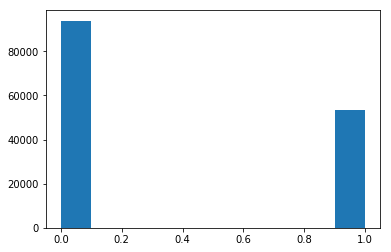

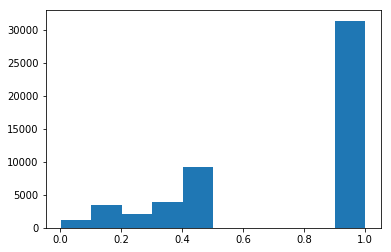

In [98]:
plt.hist(pfz)
plt.show()

plt.hist(probs_list)
plt.show()

In [ ]:
    dim = 20
    
    opt = Adam(lr=0.001)
    
    qn_table = BigTable((len(qids_seen),dim), 0, 100, init_hilo="av")
    s_table =  BigTable((len(uids_across_days), dim), 0, 100, init_hilo="av")

#     qn_switch_table = BigTable((len(qids_seen),dim), 0, 1, init_hilo="av")
#     s_switch_table =  BigTable((len(uids_across_days), dim), 0, 1, init_hilo="av")
    
    q_wgts_history = []
    s_wgts_history = []

#     s_table =  BigTable((len(userz), 1), 0, 10)
    qs_model = generate_qs_model(qn_table, s_table, opt)
    min_loss = math.inf
    max_acc = 0
    init_patience = 10
    patience = init_patience
    best_q_weights = None
    best_s_weights = None
    
#     zz = numpy.zeros((len(sz), 2*dim))
    
    for _ in range(100000):
        h = qs_model.fit(x=[qz, sz], y=pfz, epochs=1, verbose=1, shuffle=True)
#         print(h.history)
        loss = h.history['loss'][-1]
#         mse = h.history['add_w_mean_squared_error'][-1]
#         acc = h.history['sPr_prod_acc'][-1]
        mse = h.history['mean_squared_error'][-1]
        acc = h.history['acc'][-1]

#         qs_model.train_on_batch(x=[qz,sz], y=pfz)
#         loss,mse,acc = qs_model.evaluate(x=[qz,sz], y=pfz)
        print(loss, mse, acc)
        if loss <= min_loss or acc > max_acc:
            print("new min loss")
            min_loss = loss
            max_acc = acc
            best_q_weights = qn_table.get_weights()
            best_s_weights = s_table.get_weights()
            patience = init_patience
        else:
            patience -= 1
        q_wgts_history.append( qn_table.get_weights()[0] ) 
        s_wgts_history.append( s_table.get_weights()[0] )
    
        if patience == 0:
#         else:
            print("patience spent")
            break
        print("patience is now {}".format(patience))

        qn_table.set_weights(best_q_weights)
        s_table.set_weights(best_s_weights)
        
        #     ix=0
# #     if last_qn_table:
#     for lw,w in zip(last_qn_table, qn_table.get_weights()[0]):
#         if w != lw:
#             print("{} : {} - {}->{}".format(ix,qids_seen[ix],lw,w))            
#         ix+=1
#     last_qn_table = qn_table.get_weights()[0]

<__main__.BigTable object at 0x7efd47517be0> <__main__.BigTable object at 0x7efd47517ef0> Tensor("psi_select_68:0", shape=(?, 1), dtype=int32) Tensor("q_select_68:0", shape=(?, 1), dtype=int32)
psi_sel shape (?, 1)
kk (2586, 20)
selector shape (?, 1)
flat selector shape (?,)
call kk (2586, 20)
'rows' shape, (?, 20)
kk (4782, 20)
selector shape (?, 1)
flat selector shape (?,)
call kk (4782, 20)
'rows' shape, (?, 20)
Pr (?, 1)
Epoch 1/1
147165/147165 [==============================] - 18s 125us/step - loss: 5.8284 - mean_squared_error: 0.3625 - acc: 0.6375
5.82838461014 0.362510359944 0.637488533274
new min loss
patience is now 10
Epoch 1/1
147165/147165 [==============================] - 15s 103us/step - loss: 5.8222 - mean_squared_error: 0.3625 - acc: 0.6375
5.82220224937 0.362508541106 0.637488533279
new min loss
patience is now 10
Epoch 1/1
147165/147165 [==============================] - 15s 102us/step - loss: 5.8133 - mean_squared_error: 0.3625 - acc: 0.6375
5.81332426126 0.3625039

147165/147165 [==============================] - 15s 102us/step - loss: 1.7273 - mean_squared_error: 0.2336 - acc: 0.7146
1.72733341487 0.233564181073 0.714578874051
new min loss
patience is now 10
Epoch 1/1
147165/147165 [==============================] - 15s 101us/step - loss: 1.6387 - mean_squared_error: 0.2283 - acc: 0.7188
1.6387139911 0.228286087623 0.71882580777
new min loss
patience is now 10
Epoch 1/1
147165/147165 [==============================] - 15s 100us/step - loss: 1.5578 - mean_squared_error: 0.2232 - acc: 0.7231
1.55776291495 0.223193276926 0.723147487513
new min loss
patience is now 10
Epoch 1/1
147165/147165 [==============================] - 15s 102us/step - loss: 1.4836 - mean_squared_error: 0.2183 - acc: 0.7276
1.48360908876 0.218257333015 0.727577888767
new min loss
patience is now 10
Epoch 1/1
147165/147165 [==============================] - 15s 101us/step - loss: 1.4163 - mean_squared_error: 0.2135 - acc: 0.7316
1.41629171808 0.213523628375 0.731593789287
new 

147165/147165 [==============================] - 15s 99us/step - loss: 0.6249 - mean_squared_error: 0.1413 - acc: 0.8057
0.624885900256 0.141345097597 0.805721469101
new min loss
patience is now 10
Epoch 1/1
147165/147165 [==============================] - 15s 100us/step - loss: 0.6166 - mean_squared_error: 0.1405 - acc: 0.8072
0.616610750958 0.140527406032 0.807236775046
new min loss
patience is now 10
Epoch 1/1
147165/147165 [==============================] - 15s 99us/step - loss: 0.6086 - mean_squared_error: 0.1397 - acc: 0.8076
0.608628477852 0.139731525221 0.807583324837
new min loss
patience is now 10
Epoch 1/1
147165/147165 [==============================] - 15s 100us/step - loss: 0.6009 - mean_squared_error: 0.1390 - acc: 0.8086
0.600875175063 0.138956498944 0.808582203647
new min loss
patience is now 10
Epoch 1/1
147165/147165 [==============================] - 15s 100us/step - loss: 0.5934 - mean_squared_error: 0.1382 - acc: 0.8091
0.593396780502 0.138197522198 0.80907145041


147165/147165 [==============================] - 15s 102us/step - loss: 0.4463 - mean_squared_error: 0.1209 - acc: 0.8301
0.446327652736 0.120851150405 0.830143036729
new min loss
patience is now 10
Epoch 1/1
147165/147165 [==============================] - 15s 102us/step - loss: 0.4441 - mean_squared_error: 0.1205 - acc: 0.8306
0.444146582101 0.120536721122 0.830557537456
new min loss
patience is now 10
Epoch 1/1
147165/147165 [==============================] - 15s 102us/step - loss: 0.4421 - mean_squared_error: 0.1202 - acc: 0.8308
0.442054900252 0.120243738617 0.830829341221
new min loss
patience is now 10
Epoch 1/1
147165/147165 [==============================] - 15s 102us/step - loss: 0.4400 - mean_squared_error: 0.1199 - acc: 0.8314
0.440021752528 0.11993654352 0.831359358548
new min loss
patience is now 10
Epoch 1/1
147165/147165 [==============================] - 15s 102us/step - loss: 0.4381 - mean_squared_error: 0.1196 - acc: 0.8318
0.438106007535 0.119647372941 0.83176026908

147165/147165 [==============================] - 15s 102us/step - loss: 0.3968 - mean_squared_error: 0.1128 - acc: 0.8406
0.39684331587 0.112814905759 0.840634661771
new min loss
patience is now 10
Epoch 1/1
147165/147165 [==============================] - 15s 102us/step - loss: 0.3960 - mean_squared_error: 0.1127 - acc: 0.8405
0.39603918363 0.112687920989 0.84053273537
new min loss
patience is now 10
Epoch 1/1
147165/147165 [==============================] - 15s 101us/step - loss: 0.3952 - mean_squared_error: 0.1126 - acc: 0.8409
0.395242671697 0.11257465199 0.840906465533
new min loss
patience is now 10
Epoch 1/1
147165/147165 [==============================] - 15s 102us/step - loss: 0.3944 - mean_squared_error: 0.1124 - acc: 0.8409
0.394433341709 0.112449609985 0.840865694973
new min loss
patience is now 10
Epoch 1/1
147165/147165 [==============================] - 15s 102us/step - loss: 0.3936 - mean_squared_error: 0.1123 - acc: 0.8412
0.393608773579 0.112329081144 0.841191859478
n

147165/147165 [==============================] - 15s 102us/step - loss: 0.3692 - mean_squared_error: 0.1089 - acc: 0.8452
0.369248396975 0.108923287264 0.84522135019
new min loss
patience is now 10
Epoch 1/1
147165/147165 [==============================] - 15s 102us/step - loss: 0.3689 - mean_squared_error: 0.1089 - acc: 0.8453
0.368895799957 0.108859769235 0.845330071689
new min loss
patience is now 10
Epoch 1/1
147165/147165 [==============================] - 15s 102us/step - loss: 0.3685 - mean_squared_error: 0.1088 - acc: 0.8452
0.368513345167 0.108792529948 0.845194169814
new min loss
patience is now 10
Epoch 1/1
147165/147165 [==============================] - 15s 102us/step - loss: 0.3682 - mean_squared_error: 0.1087 - acc: 0.8453
0.368197309776 0.108738383865 0.845302891318
new min loss
patience is now 10
Epoch 1/1
147165/147165 [==============================] - 15s 102us/step - loss: 0.3679 - mean_squared_error: 0.1087 - acc: 0.8454
0.367856416671 0.108682698534 0.84539802263

147165/147165 [==============================] - 15s 104us/step - loss: 0.3567 - mean_squared_error: 0.1071 - acc: 0.8472
0.356740029383 0.107071214375 0.847232697993
new min loss
patience is now 10
Epoch 1/1
147165/147165 [==============================] - 15s 103us/step - loss: 0.3566 - mean_squared_error: 0.1070 - acc: 0.8471
0.356558994104 0.107045823751 0.847117181392
new min loss
patience is now 10
Epoch 1/1
147165/147165 [==============================] - 15s 103us/step - loss: 0.3563 - mean_squared_error: 0.1070 - acc: 0.8475
0.356322715483 0.106997593951 0.847511296838
new min loss
patience is now 10
Epoch 1/1
 84096/147165 [================>.............] - ETA: 6s - loss: 0.3556 - mean_squared_error: 0.1066 - acc: 0.8478

In [164]:
# D | acc
# 30| .647
# 20| .851
# 10| .842
#  7| .835
#  5| .826
#  1| .777


xs = range(len(q_wgts_history))
ww = qn_table.get_weights()[0].shape[0]

print(len(q_wgts_history))

print(ww)

51
2586


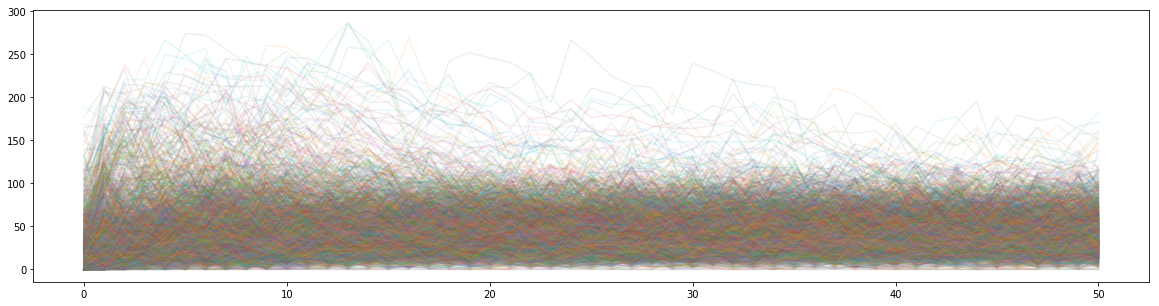

triangular_flying_num|3d09e624-781e-4938-b20a-89bce1ca82b8 0.0 0
bed_of_nails|fc99faf7-d949-44df-ad37-56443d4d0898 0.102969177067 1
corner_retroreflector|b3c02554-5880-471a-a6ea-213a6607ad90 0.225800313056 20
aligning_dipoles|366de9eb-5910-4d53-ac49-6c5e43a89ce2 0.231093637645 20
addition_of_angles1_multi|22b462f5-4a25-4c99-9875-aee3c734c333 0.28197185602 20
ch_c_p4|1c512070-59cd-4bb5-a7dc-2912b23cd430 0.544612705708 2
ch_d_p8|488842fd-31ec-4e2b-8ca2-b60392866160 1.04832160473 2
factorise_2_num|46ee77b5-d6f5-4af3-bf73-87647dcf5b72 1.67647482455 4
free_energy|5116f9d1-0504-4687-a770-2eddb87162fc 2.27244283259 5
ch_b_p1|fbcf350b-41fa-4031-bd9c-02f1d173f9e4 2.56651996076 6
making_bulbs_brighter|4741acf9-b74e-4d07-a6cc-3176aa6301b0 2.57977238484 4
ch_a_p1|07708e0a-644b-4e64-a9db-c85c725a5242 2.61992298067 2
ch_a_p8|a3a74812-d9f3-4a6d-a6a1-6cbb61260a7c 2.72272926569 5
energy_in_a_wire|a26227f4-bde0-41d3-b379-52629129b82d 2.75456847809 3
helical_path|b9ce1390-810a-4604-aaa1-772915309831 2.83

target_practice|752c1d84-0e42-4091-b4e9-3b807bfc79b6 35.7954364519 16
ch_b_p6|b52443de-8a2e-4daa-936f-f70560c7b858 35.8175207824 20
ch_i_p3|501099c0-cc7b-4104-87e1-a24234cf8497 35.8341989219 17
ch_d_p2|c39c0245-30ea-421b-a3bf-95b52cc0a099 35.8533923677 14
braking_a_car|dc2d3430-f62c-447f-804b-17869fb59bcd 35.8985657394 10
ch_a_p3|b872c257-1ce7-42cc-aee7-e00704393391 35.9411259425 20
ch_b_p5|48b0f282-380a-4044-9104-f0c4c4ef4bdc 35.9739355845 18
single_slit_diffraction|5c8ef431-e962-456b-92ce-2f894961df5b 36.0805041866 19
value_units_momentum1|b247f6f9-b4f4-43f7-88dd-c12e4284c775 36.10546659 19
ch_b_p6|bc1b61fa-034f-428f-b894-5a8ce396e8b9 36.1286045546 15
ch_c_p2|5ef5cc1c-fc56-435b-bb51-c3d71e2d9b68 36.1294761635 17
linear_quadratic1_multi|951c237e-97f4-4015-a269-1d84d226a8a7 36.1457428522 10
fasttrack_core_4|7ea22065-363e-43fb-9e49-77bb218a92be 36.1643718102 20
ch_d_p5|c658d36a-a925-4131-a264-f9362e335905 36.1912978274 20
ch_e_p4|ab19a88a-8161-46f2-81d7-362e5aa768f8 36.1943017459 19
ch_

quadratic_formula_3_num|5a470c25-61cb-49c2-843b-153487995980 64.883962977 20
fasttrack_core_9|9400dc75-bb4d-4350-967f-0c550c593c87 64.9088624995 19
exponentials_radioactive_decay|39832650-48c6-47ba-9e29-54714f8305e0 64.9311253428 15
heating_an_electric_fire|3b5b72b4-19c8-431a-92ed-eb5b718e7ff1 64.9364106557 20
oil_drop_multiple_fields_num|ebe027e6-291a-4d51-993d-ff89c68e15ad 64.9416550919 12
hansel_and_gretel|4bb59a42-ba0d-41ef-a85c-dd548cfbbc88 64.9440713525 18
series_resistors|aa91f182-4070-bf3d-81a505d33b0a 64.9541665278 19
ch_a_p8|055ec301-25d6-4e6e-8840-721bf1b7aea7 64.9716443419 18
symmetry_and_com_num|848f4703-4891-46d8-b93a-1951ff84aa58 65.0201583952 20
conical_pendulum|e39df943-e044-4245-894d-b7677f104c59 65.2353851632 20
rayleigh_scattering|67524ae6-697c-4b45-b4e4-1d9cefa2a67a 65.3181423545 17
saving_money|96fffe70-d517-496a-a8b9-94ce6f057337 65.3414680362 17
infinite_resistors|71cb22f9-2697-4e03-8f95-c4a0010c569c 65.505926786 20
rearrange_reciprocal1_multi|d2d23ae6-829a-46c0

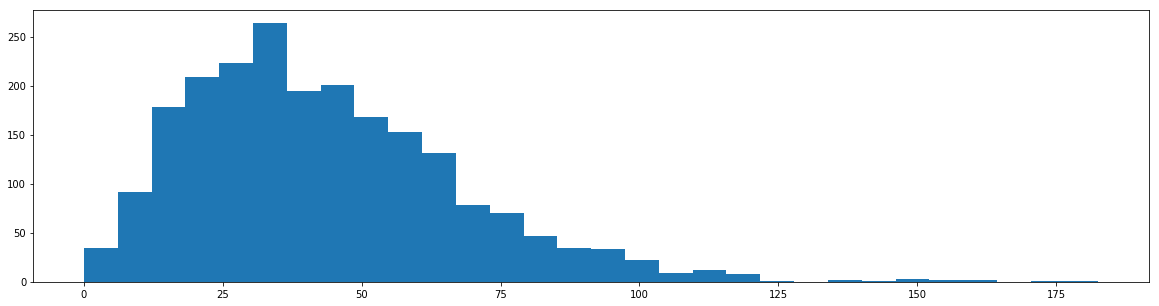

In [165]:
q_pairs = []
q_book_tups = []
for wix in range(ww):
#     if not (qids_seen[wix].startswith("ch_") or qids_seen[wix].startswith("ch-")):
#         continue
    mags = []
    ncs = []
    for hix in xs:
        wgts = q_wgts_history[hix][wix]
#         mag = numpy.linalg.norm(wgts) # calculate the Frobinius norm
        mag = sum(wgts)
        n_comps = numpy.sum(wgts > 0)
        mags.append(mag)
    if mags[0] != mags[-1]:
        q_pairs.append((qids_seen[wix], mag, n_comps))
        if (qids_seen[wix].startswith("ch_") or qids_seen[wix].startswith("ch-")):
            q_book_tups.append((qids_seen[wix],mag, wgts, n_comps))
        plt.plot(xs,mags, alpha=0.1)
plt.gcf().set_size_inches(20,5)
plt.show()

q_pairs.sort(key=lambda x: x[1])
hist_data = []
for p in q_pairs:
    hist_data.append(p[1])

for p in q_pairs:#[0:100]:
    print(p[0], p[1], p[2])
print("...")
# for p in q_pairs[-100:]:
#     print(p[0], p[1], p[2])

numpy.savetxt("./{}d_all_qs.csv".format(dim), q_pairs , fmt="%s", delimiter=",")
bookpairs=[(p[0],p[1]) for p in q_book_tups]
bookpairs.sort(key=lambda x: x[1])
numpy.savetxt("./{}d_book_qs.csv".format(dim), bookpairs , fmt="%s", delimiter=",")

plt.hist(hist_data, bins=30)
plt.gcf().set_size_inches(20,5)
plt.show()
    

[[ 48.86263275  50.53866577  45.76177597 ...,  49.53988647  49.07385254
   46.83073807]
 [ 44.68473434  47.01397705  45.25283051 ...,  44.23267365  50.96555328
   45.57000732]
 [ 50.39331055  49.43642426  50.88883209 ...,  47.55753708  49.22686005
   47.829216  ]
 ..., 
 [ 46.90827942  44.35851669  54.36176682 ...,  54.1046524   52.67159271
   52.80357361]
 [ 50.22428513  47.76909637  53.3274765  ...,  48.82571411  51.06389618
   52.77271271]
 [ 48.84952927  46.43883514  49.96690369 ...,  45.30160904  44.48859787
   51.70840836]]
4782


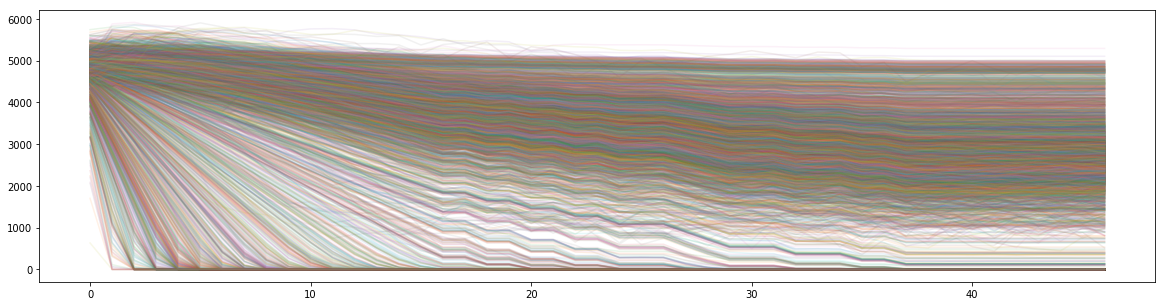

10008_2015-09-17 2801.84812927 100
10008_2015-09-25 1914.78857565 100
10008_2015-09-28 1516.94533396 100
10008_2015-09-29 1982.00837564 100
10008_2015-10-01 0.0 0
10008_2015-10-13 4747.53424072 100
10008_2015-10-15 2104.19223571 100
10008_2015-11-16 2210.39660859 100
10008_2015-11-24 3900.99214268 100
10020_2015-09-17 2608.64138889 100
10020_2015-11-09 0.0 0
10020_2015-11-16 2585.3702817 100
10020_2015-11-30 3293.52982903 100
10020_2016-04-19 3519.57383728 100
10034_2015-09-17 2099.41820908 100
10036_2015-09-17 4080.01972008 100
10077_2015-09-21 2675.19299221 100
10077_2015-09-23 2325.80763721 100
10077_2015-09-29 4042.39619637 100
10077_2015-10-02 3104.54891109 100
10077_2015-10-04 2545.95373726 100
10077_2016-05-19 3017.11815596 100
10077_2016-05-20 0.0 0
10080_2015-10-14 2104.76914215 100
10080_2016-01-31 2643.99099541 100
10080_2016-06-08 0.0 0
10112_2015-09-22 2907.24611664 100
10112_2015-10-07 2905.69413948 100
10112_2015-11-03 3687.30095959 100
10112_2015-11-10 3253.95924568 100

In [162]:
from random import shuffle

# swgts = s_table.get_weights()[0]
# print("student range:", min(swgts), max(swgts))

uids_across_days = list(uids_across_days)
# uids_across_days = sorted(uids_across_days)

# print(uids_across_days)
# for u in uids_across_days[0:100]:
#     print(u)

xs = range(len(s_wgts_history))
# ww = s_wgts_history[0][0]
print(s_wgts_history[0])

u_pairs = []
unchanged = set()

ww_choices = numpy.random.choice(uids_across_days, size=min(len(uids_across_days),20000), replace=False)
# ww_choices = uids_across_days
print(len(ww_choices))
for uid in ww_choices:
    uix = uids_across_days.index(uid)
    mags = []
    for hix in xs:
        wgts = s_wgts_history[hix][uix]
#         mag = numpy.linalg.norm(wgts) # calculate the Frobinius norm
        mag = sum(wgts)
        n_comps = numpy.sum(wgts > 0)
        mags.append(mag)
    if mags[0] == mags[-1]:
        unchanged.add(uid)
    else:
        u_pairs.append((uid, mag, n_comps))
        plt.plot(xs,mags, alpha=0.1)
plt.gcf().set_size_inches(20,5)
plt.show()

# u_pairs.sort(key=lambda x: x[1][0])
# hist_data = []
# for p in u_pairs:
#     print(p[0], p[1][-1])
#     hist_data.append(p[1][-1])

for p in sorted(u_pairs)[0:100]:
    print(p[0], p[1], p[2])
print("--")
for p in sorted(u_pairs)[-100:]:
    print(p[0], p[1], p[2])

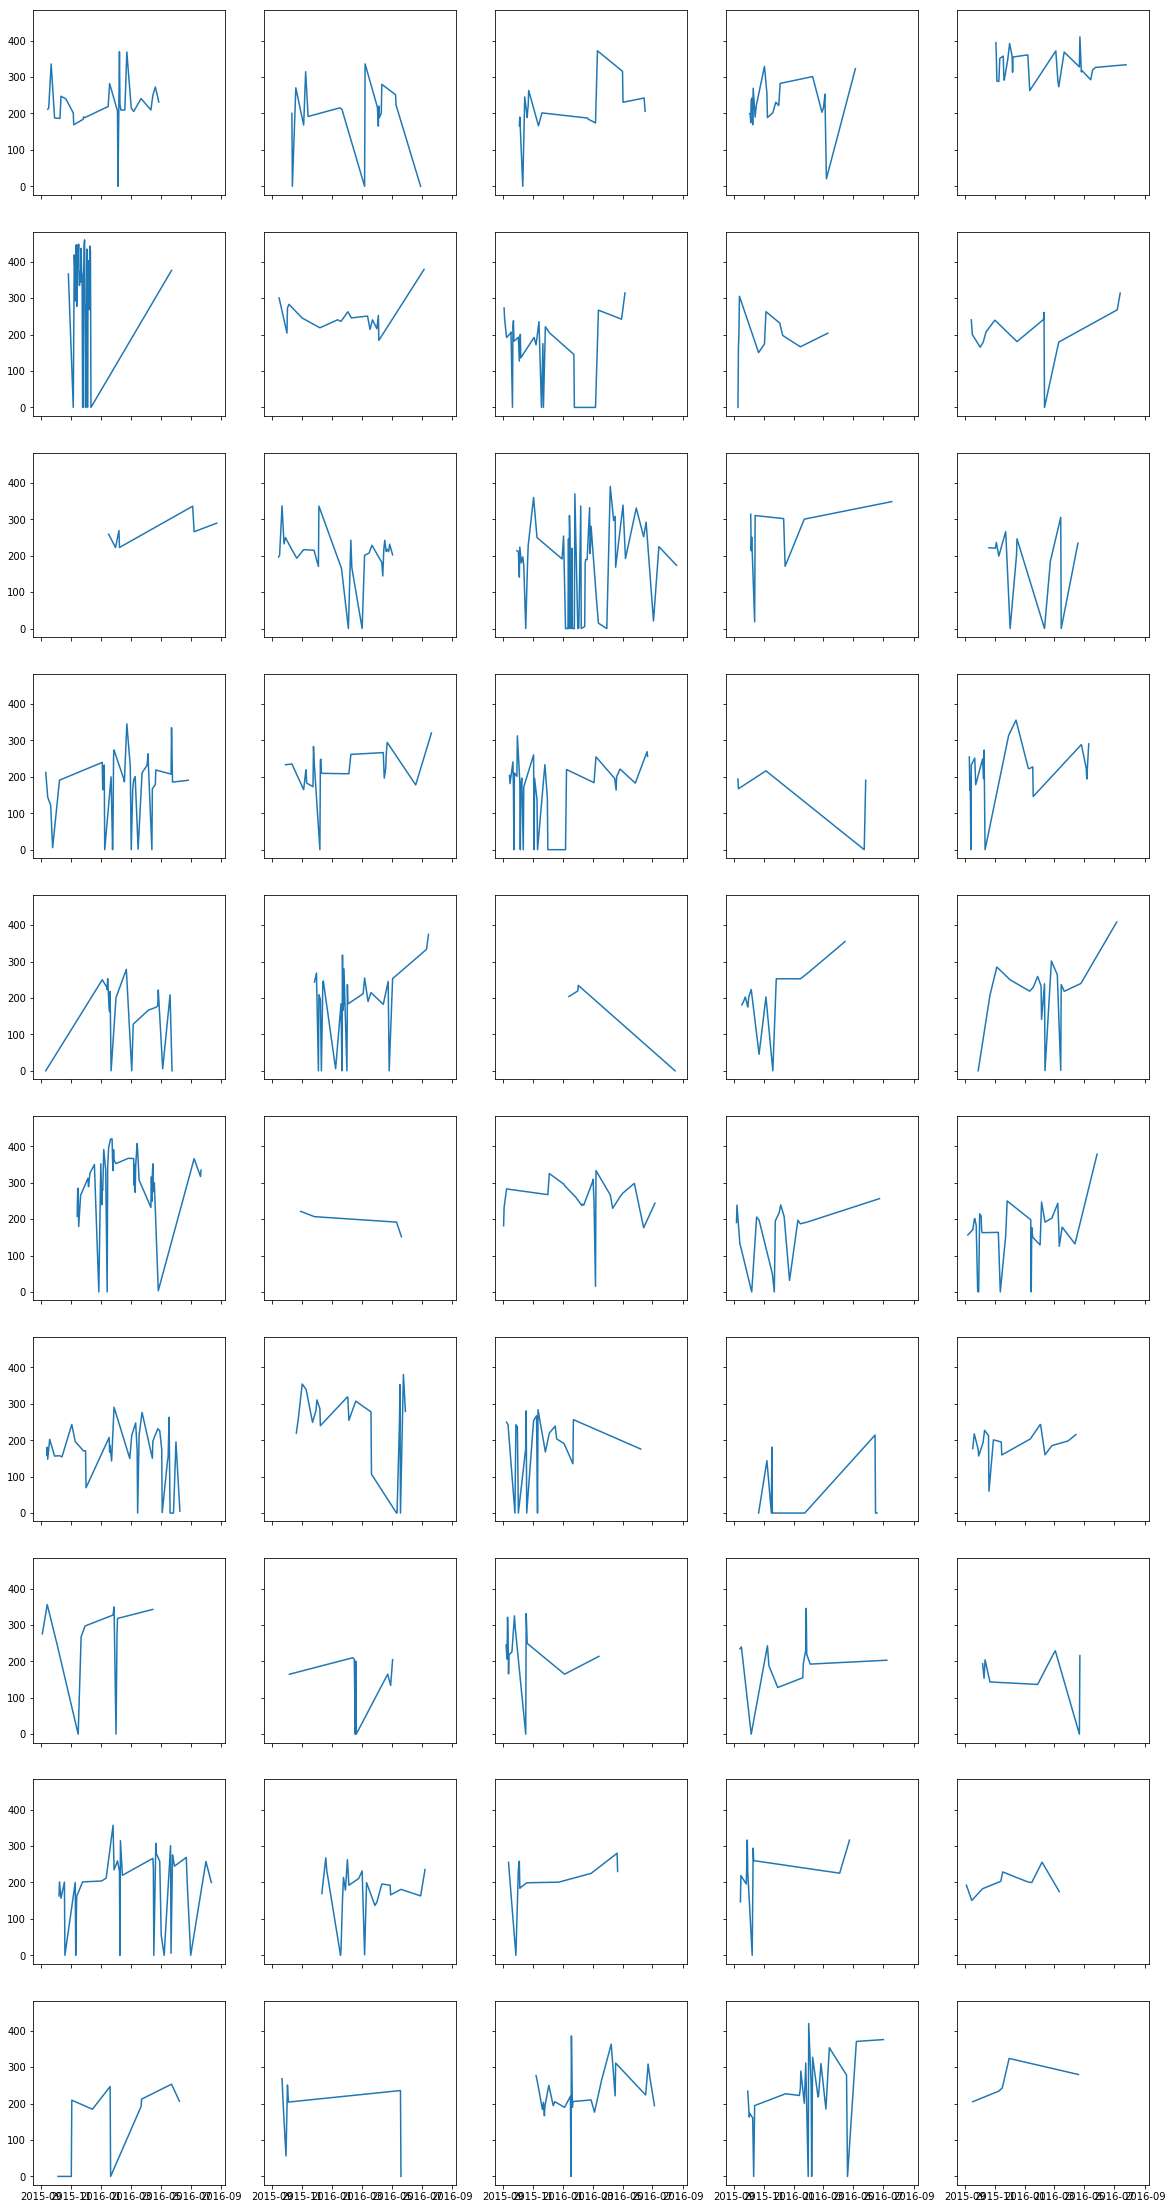

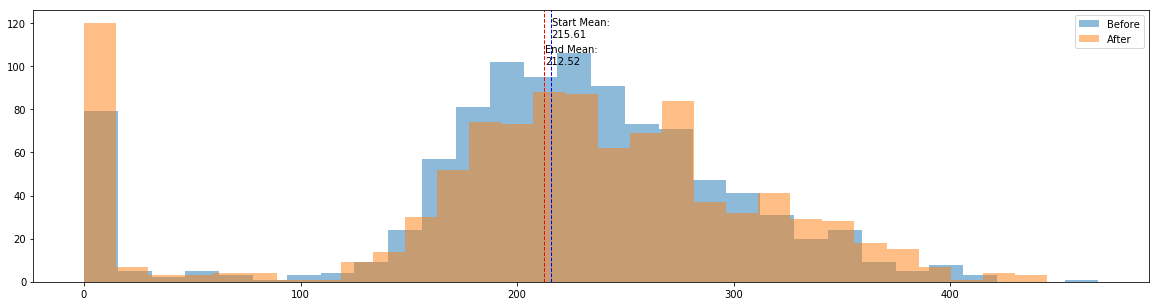

1000
221.896142244 86.8188912417
224.255998135 101.163327677
12 4770


In [137]:
from datetime import datetime
u_dt_map = defaultdict(dict)
st_hist_data = []
ed_hist_data = []
for p in u_pairs:
    ustr = p[0].split("_")[0]
    dt = datetime.strptime(p[0].split("_")[1].split(" ")[0], "%Y-%m-%d")
    u_dt_map[ustr][dt]=p[1]

# for k in u_dt_map:
#     dts = sorted(u_dt_map[k])
#     st_hist_data.append(u_dt_map[k][dts[0]])
#     ed_hist_data.append(u_dt_map[k][dts[-1]])

kct=0
cols = 5
rows = 10
f,pltz = plt.subplots(rows,cols, sharey=True, sharex=True)
for k in u_dt_map:
#     if len(u_dt_map[k]) < 10:
#         continue
    dts = sorted(u_dt_map[k])
    delta = (max(dts) - min(dts))
    
#     d = datetime(1979,7,16)/
    d = delta.days
    st_hist_data.append(u_dt_map[k][dts[0]])
    ed_hist_data.append(u_dt_map[k][dts[-1]])

    if d < 180:
        continue    
#     print(k,":", dts)
    mgs = [u_dt_map[k][dt] for dt in dts]
#     print(mgs)
#     print(kct, kct//cols, kct%cols)
    if kct<(cols*rows):
        pltz[kct//cols, kct%cols].plot_date(x=dts, y=mgs, label=k, ls="-", fmt="")
    kct+=1
    
plt.gcf().set_size_inches(20,40)
# plt.ylim(0)
plt.show()
    
# print("...")
# for el in unchanged:
#     print(el)
    
st_mean = numpy.mean(st_hist_data)
ed_mean = numpy.mean(ed_hist_data)

plt.hist(st_hist_data, alpha=0.5, label="Before", bins=30)
plt.axvline(numpy.mean(st_mean), color='blue', linestyle='dashed', linewidth=1)
plt.hist(ed_hist_data, alpha=0.5, label="After", bins=30)
plt.axvline(numpy.mean(ed_mean), color='red', linestyle='dashed', linewidth=1)

_, max_ = plt.ylim()
plt.text(st_mean+0.3, max_ - max_/10, 'Start Mean:\n{:.2f}'.format(st_mean))

plt.text(ed_mean+0.3, 
         max_ - max_/5, 
         'End Mean:\n{:.2f}'.format(ed_mean))

plt.gcf().set_size_inches(20,5)
plt.legend()
plt.show()

print(len(st_hist_data))
print(numpy.median(st_hist_data), numpy.std(st_hist_data))
print(numpy.median(ed_hist_data), numpy.std(ed_hist_data))
print(len(unchanged), len(u_pairs))

## Student calibration and change over time

### Daily snapshots
For a student s, the student's attempts at questions are partitioned into daily snapshots: {s0, s1, s2 ...}
For the purposes of calibration, student snapshots are mutually independent: that is the scores for sm are conditionally independent of the scores for sn n!=m.  The independence is conditional because information is transmitted via the calibration of the questions encountered on day n: {q}\_n.

Note that since a student cannot pass an item twice, it's impossible for two "passes" on different days to exist.  It is possible for a student to make several failed attempts at an item, and then pass it on a later date.  Since item calibrations hold across all time, but students are recalibrated daily, the student's ability will be calibrated such that it "straddles" the item across this timeframe.

An example of a student's scores over time:

10214_2015-11-09 169.724 20

10214_2015-11-10 192.286 20

10214_2015-11-11 201.752 20

10214_2016-05-10 196.241 20

10214_2016-05-15 202.679 20

10214_2016-05-16 201.018 20

10214_2016-05-20 182.211 20

10214_2016-05-21 184.925 20

10214_2016-06-23 190.13 20



[266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,

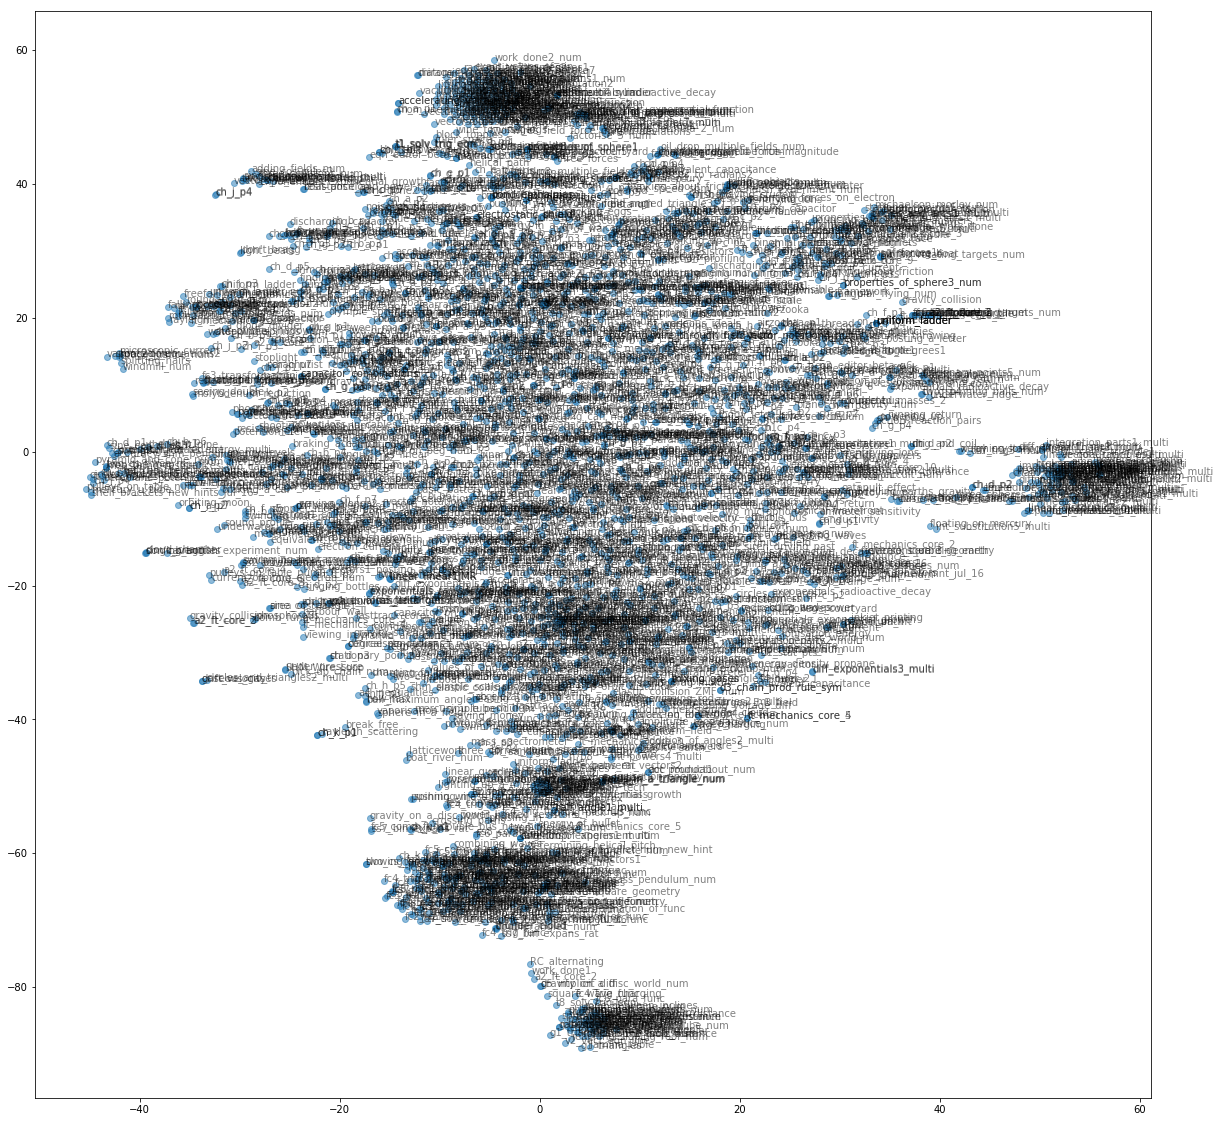

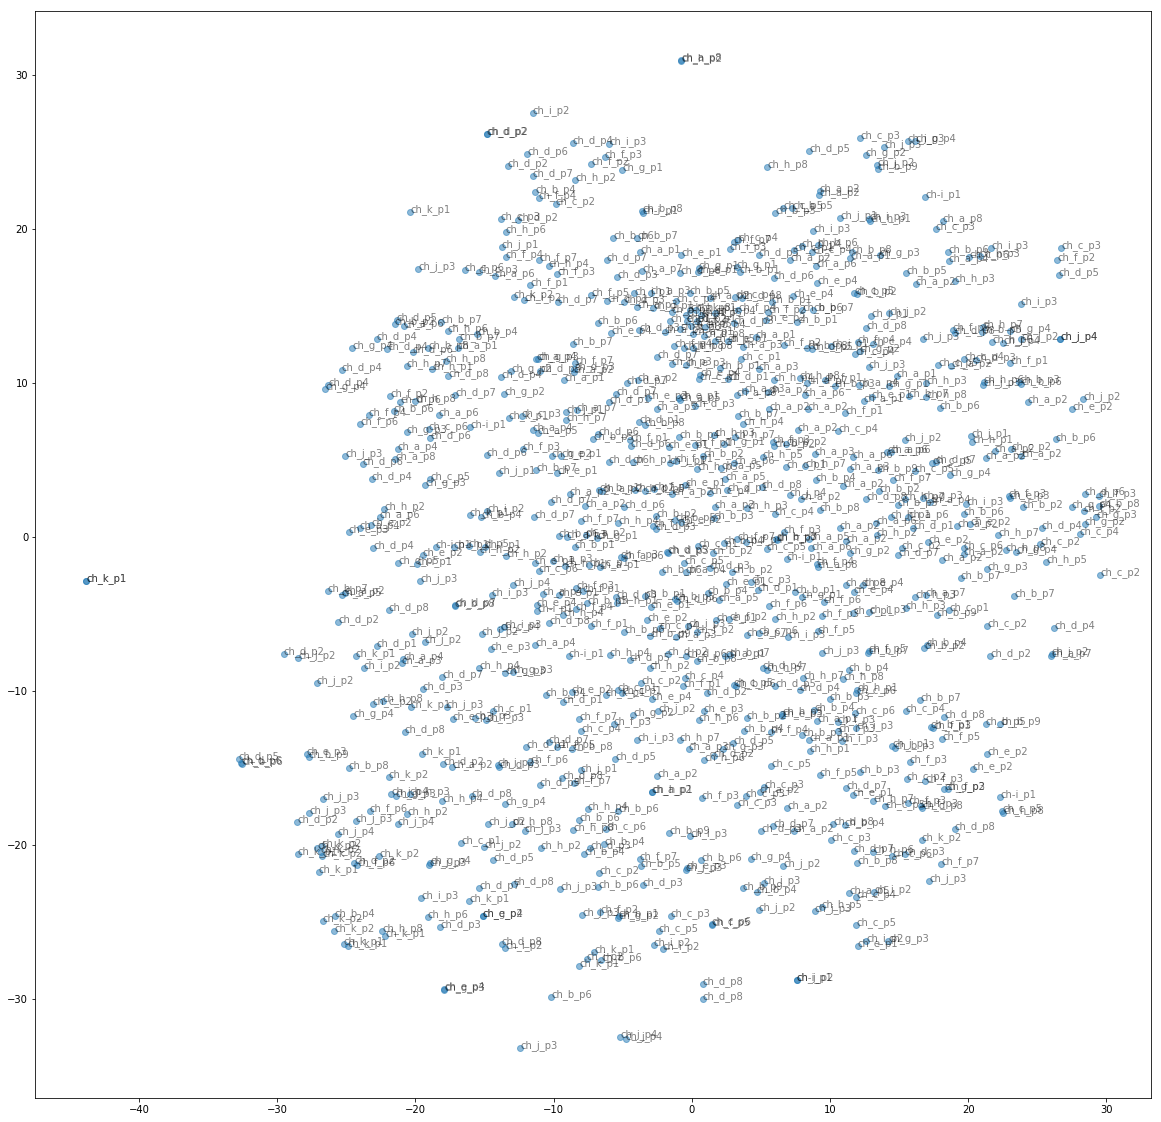

In [136]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
indices = [qids_seen.index(tup[0]) for tup in q_book_tups]
print(indices)

mutate = TSNE(n_components=2)
warr = numpy.array([qn_table.get_weights()[0][qids_seen.index(qid)] for qid in [tup[0] for tup in q_pairs]])

data_flat = mutate.fit_transform(warr)
# data_flat = warr

# plt.scatter(x=[tvp[2][0] for tvp in q_book_tups], y=[tvp[2][1] for tvp in q_book_tups])
plt.scatter(x=data_flat[:,0], y=data_flat[:,1], alpha=0.5)

for ix,tup in enumerate(q_pairs):
#     qix = qids_seen.index(tup[0])
    L = tup[0].split("|")[0]
    plt.annotate(L, (data_flat[ix,0], data_flat[ix,1]), alpha=0.5 )
plt.gcf().set_size_inches(20,20)
plt.show()


warr = numpy.array([tup[2] for tup in q_book_tups])
data_flat = mutate.fit_transform(warr)
# data_flat = warr
# plt.scatter(x=[tvp[2][0] for tvp in q_book_tups], y=[tvp[2][1] for tvp in q_book_tups])
plt.scatter(x=data_flat[:,0], y=data_flat[:,1], alpha=0.5)

for ix,tup in enumerate(q_book_tups):
#     qix = qids_seen.index(tup[0])
    L = tup[0].split("|")[0]
    plt.annotate(L, (data_flat[ix,0], data_flat[ix,1]), alpha=0.5 )
plt.gcf().set_size_inches(20,20)
plt.show()

In [ ]:
for ix,q in enumerate(qn_table.get_weights()[0]):
    print(ix, qids_seen[ix], q)

In [ ]:
for ix,s in enumerate(s_table.get_weights()[0]):
    print(ix, uids_across_days[ix], s)

In [ ]:
plot_w = 6
plot_h = (1+len(d_hist_data)//plot_w)

# fig, axes = plt.subplots(nrows=(len(d_hist_data)), ncols=1)            
plt.gcf().set_size_inches(3*plot_w,3*plot_h)
for ax_i, d in enumerate(d_hist_data):
    data = d_hist_data[d]
    print(d, len(data))
#     print(min(data), max(data))
#     print(data)
    subplot = plt.subplot(plot_h, plot_w, ax_i+1)
    subplot.hist(data)
plt.show()

print(len(d_hist_data), "days of activity")
print(len(qids_seen), "qids")
print(len(uids_seen), "uids")
print(len(book_qids), "book qids")
print(book_qids)
            
#         for item in attz4date[attz4date["question_id"]==qid].loc[["user_id", "correct"]]:
#             print("\t",item)
        

In [ ]:
print(passes)
plt.hist(passes)
plt.show()

In [ ]:
# assignments.loc[:, "creation_date"] = pandas.to_datetime(assignments["creation_date"]).dt.floor("D")
# pid_override = set()
# for h in ass_summ["hexes"]: # go through all hexes ever assigned...
#     pid_override.update(eval(h))
# pid_override = sorted(list(pid_override))

LOAD_PQIDS=True

if LOAD_PQIDS:
    pid_override = joblib.load(base+"pid_override.pkl")
    all_qids = joblib.load(base+"all_qids.pkl")
    print("loaded pqids....")

else:
    pid_override = set()
    qids_in_play = set()
    ss = set()
    for aix in ass_summ.index:
        ss.update(eval(ass_summ.loc[aix,"students"]))
        # hxz = [h for h in eval(ass_summ.loc[aix,"hexes"]) if (h.startswith("ch_") or h.startswith("ch-i"))]
        # ass_summ.loc[aix, "hexes"] = str(hxz)

    for s in ss:
        attz = get_attempts_from_db(s)
        qids_in_play.update([q for q in list(attz["question_id"])])# if (q.startswith("ch_") or q.startswith("ch-i"))] )
        pid_override.update([s.split("|")[0].replace("-","_") for s in list(attz["question_id"]) if (s.startswith("ch_") or s.startswith("ch-i"))])
    all_qids = sorted(qids_in_play)
    pid_override = sorted(pid_override)
    all_page_ids = pid_override

    print(all_qids)
    print("Qids in play len", len(all_qids))

    print(pid_override)
    print("Pids in play len", len(pid_override))
    joblib.dump(all_qids, base+"all_qids.pkl")
    joblib.dump(pid_override, base+"pid_override.pkl")
    
all_page_ids = list(set([ s.split("|")[0] for s in all_qids ]))
print(all_page_ids)
print(len(all_page_ids))

In [ ]:
import copy
from hwgen.common import get_user_data
start_dates = {}
ss = set()
first_assign = {}
min_ts = None
max_ts = None
for aix in ass_summ.index:
    ts, grid, students = ass_summ.loc[aix,["creation_date","group_id","students"]]
    
    if (not min_ts) or ts < min_ts:
        min_ts = ts
    if (not max_ts) or ts > max_ts:
        max_ts = ts
    
    students = eval(students) # convert str rep to list
    ss.update(students)
    for s in students:
        if s not in first_assign:
            first_assign[s] = copy.copy(ts)
psi_df = get_user_data(list(ss))
for ix in psi_df.index:
    psi, rd = psi_df.loc[ix, ["id","registration_date"]]
    if psi not in start_dates:
        ts = first_assign[psi]
        reg_date = pandas.Timestamp(psi_df.loc[psi_df["id"]==psi,"registration_date"].values[0])
        start_dates[psi] = (ts, reg_date)

for s in start_dates:
    print(s, start_dates[s])

print(min_ts, max_ts)

In [ ]:
BUILD_SXUA = False
# print(ass_summ[0:10])
numpy.set_printoptions(precision=1, suppress=True)
if BUILD_SXUA:
    print("getting start dates")
#     try:
#         start_dates = joblib.load(base + "start_dates.pkl")
#         print("loaded")
#     except:
#         start_dates = build_start_dates(ass_summ)
    if True:
        joblib.dump(start_dates, base+"start_dates.pkl")
        print("built")
    ass_summ = ass_summ[ass_summ["has_book_hexes"] == True]  # discard activity that has nowt to do with the book
#     for psi in list(start_dates.keys())[0:10]:
#         print(psi, start_dates[psi])
    print("building SXUA")
    SXUA = build_SXUA(base, ass_summ, all_qids, pid_override=pid_override, start_dates=start_dates)
    f = open(base + "SXUA.comp.pkl", 'wb')
    pickle.dump(SXUA, f)
    f.close()
    print("compressed and SAVED")
else:
    print("loading SXUA")
    f = open(base + "SXUA.comp.pkl", 'rb')
    SXUA = pickle.load(f)
    print("SXUA loaded with {} entries", len(SXUA))
    f.close()

In [ ]:
print(len(SXUA))
for k in SXUA:
#     print(k)
    tss = SXUA[k]
    print("{}: ({} {}), {} ".format(k, min(tss), max(tss), len(tss)))

In [ ]:
# ass_summ = ass_summ[0:8000]
ass_summ = ass_summ[ass_summ["has_book_hexes"]==True] # discard activity that has nowt to do with the book
# ass_summ = ass_summ[ass_summ["num_hexes"]==1] # discard activity that has nowt to do with the book
print("ass summ pre filtered, shape {}".format(ass_summ.shape))
ass_summ = ass_summ[ass_summ["include"]==True]
print("ass summ post filtered, shape {}".format(ass_summ.shape))

tss = ass_summ.loc[:,"creation_date"]
print(numpy.min(tss), numpy.max(tss))

In [ ]:
# import zlib
# numpy.set_printoptions(precision=1, suppress=True)

# for ix in ass_summ.index[0:100]:
#     aid,stz,ts = ass_summ.loc[ix,["id","students","creation_date"]]
#     stz = eval(stz)
#     print("----Aid =",aid)
#     for psi in stz:
#         psi_sxua = SXUA[psi]
# #         for ts in psi_sxua:
#         S,X,U,A = pickle.loads(zlib.decompress(psi_sxua[ts]))
#         print(aid,psi,ts,S)

In [ ]:
numpy.set_printoptions(precision=4, suppress=True)
aug = augment_data(ass_summ, SXUA, pid_override, filter=True)
aid_list, s_list, x_list, u_list, a_list, y_list, psi_list, hexes_to_try_list, hexes_tried_list, _, gr_id_list, ts_list, maxdops = aug

In [ ]:
# import sys
# i=0
# for aid, psi, sl,xl,ul,al,hxtt,hxtd in zip(aid_list, psi_list, s_list,x_list,u_list,a_list,hexes_to_try_list, hexes_tried_list):
#     print(psi,":",aid,":",sl)
# #     print([x for x in xl])
#     print("...",sum(xl), numpy.nonzero(xl))
#     print([all_qids[ix] for ix in numpy.nonzero(xl)[0]])
#     i += 1
#     if i == 1000:
#         break
# #     print(xl)
# #     print(y_list)

In [ ]:
COUNT_TEACHERS=False
if COUNT_TEACHERS:
    t_test = None
    t_train = None
    ct = Counter()
    for t in numpy.unique(ass_summ["owner_user_id"]):
        t_assignments = ass_summ[ass_summ["owner_user_id"] == t]
        ct[t] = ass_summ.shape[0]
    print(ct.most_common(20))
    print("teachers counted")

    assct = 0
    teacherct = 0
    kept_ts = []
    for (t, tct) in list(ct.most_common(len(ct))):
        t_assignments = ass_summ[ass_summ["owner_user_id"] == t]
        this_t_assts = t_assignments.shape[0]
        if this_t_assts < 5:
            print("not enough assignments",t,tct,this_t_assts)
        else:
            teacherct += 1
            kept_ts.append((t,ct[t]))
    print(teacherct, assct)

    teacherN = teacherct
    test_insts = 0
    target_test = 6000 #teacherN // 10

    t_test = []
    t_train = []
    put_in_test_set = False
    n_train = 0
    n_test = 0
    for (t, tct) in kept_ts:
        num_students = 0
        t_assignments = ass_summ[ass_summ["owner_user_id"] == t]
        print(t,":",t_assignments.shape[0], "new training assts")

        if put_in_test_set and n_test<target_test:
            # test_insts += 1
            print("TEST>>")
            aug = augment_data(t_assignments, SXUA, pid_override=pid_override, filter=True)
            num_students = len(aug[0])
            n_test += num_students
            if len(t_test) == 0:
                t_test = t_assignments
            else:
                t_test = pandas.concat([t_test, t_assignments])
            put_in_test_set = False
        else:
            print("TRAIN>>")
            aug = augment_data(t_assignments, SXUA, pid_override=pid_override, filter=False)
            num_students = len(aug[0])
            n_train += num_students
            if len(t_train) == 0:
                t_train = t_assignments
            else:
                t_train = pandas.concat([t_train, t_assignments])
            put_in_test_set = True

        if n_train >= 50000:
            break

    tr = t_train
    tt = t_test
    print("numbers of (student,asst) pairs:", n_train, n_test)
    tr.to_csv(base + "tr_ttb.csv")
    tt.to_csv(base + "tt_ttb.csv")
else:
    tr = pandas.read_csv(base + "tr_ttb.csv")
    tt = pandas.read_csv(base + "tt_ttb.csv")

print("len t_train, t_test",len(tr), len(tt))
ass_summ = pandas.concat([tr,tt])
print("Split complete!")
print("{} {}".format(len(tt), len(tr)))

In [ ]:
do_x_val = True
xrmses = []
xaccs = []
if do_x_val:
    n_folds = 10
    start_indices = [len(tr)*x//n_folds for x in range(n_folds)]
    print(start_indices)
    fold_size = len(tr)//n_folds
    for start_target in start_indices:
        ttx = tr[start_target:(start_target+fold_size)]        
        trx = tr.drop(tr.index[range(start_target,start_target+fold_size)])
        aug_trx = augment_data(trx, SXUA, pid_override=pid_override, all_qids=all_qids, all_page_ids=all_page_ids, filter=False)
        modelx = train_deep_model(aug_trx)
        aug_ttx = augment_data(ttx, SXUA, pid_override=pid_override, all_qids=all_qids, all_page_ids=all_page_ids, filter=False)
        (rmse,acc) = evaluate3(aug_ttx, modelx, pid_override)
        xrmses.append(rmse)
        xaccs.append(acc)
        

In [ ]:
print(xrmses)
print(xaccs)
print(numpy.mean(xrmses))
print(numpy.mean(xaccs))

In [ ]:
    model = train_deep_model(aug)
    print("...deleted original X,y")
    model.save(base + 'hwg_model.hd5')
    # joblib.dump(xmask, base + 'hwg_xmask.pkl')
    # joblib.dump(sc, base + 'hwg_mlb.pkl')
    # joblib.dump((sscaler,levscaler,volscaler), base + 'hwg_scaler.pkl')
    print("saved model and exit")